---
<h2> 프로젝트 추진 배경 </h2>

- wafer 수율 미달 시, 알람 발생하며 공정 정지
- 하지만, 수율 조건을 만족하면서 **defect이 지속적으로 발생하는 경우**엔 공정 엔지니어가 직접 확인하지 않으면 알 수 없음.
- 이 문제는 그저 wafer위의 이물질을 닦아내면 해결할 수 있는 문제이지만, 시스템은 이를 불량품이라 판단하고 제거함.
- 낙숫물이 댓돌을 뚫는다는 말이 있듯이, 해당 defect이 수 일간 방치된다고 가정하면 수십억대의 손실이 발생할 수 있음.
- 수율 조건을 만족하면서, 연속적으로 발생하는 defect을 탐지하는 알고리즘을 개발하여 손실을 사전에 방지하고자 함.


1. parsing
2. 장비이상검증
3. Lot 이상검증
4. wafer 이상검증

---
## 데이터 개요
- 반도체 검사장비 2대에서 추출한 KLARF 파일 1000개.
- batch process
    - Foup : wafer 25장이 포함된 batch 
    - 현장에선 25장을 채워서 넣진 않음. 
    - foup안에 25장이 있을수도.. 7장,.. 1장.. 다 다름.
    - 이 foup을 Lot-ID로 지정. ex) AS10001T
    - 이 foup을 재검사하는 경우, ex) AS10001T1 

- Lot-ID : 같은 공정을 가진 일련의 
- Wafer-ID
- 현재 이 데이터셋에선 이물이 계속 발생하는 case에서 
    

---
## Flow Chart

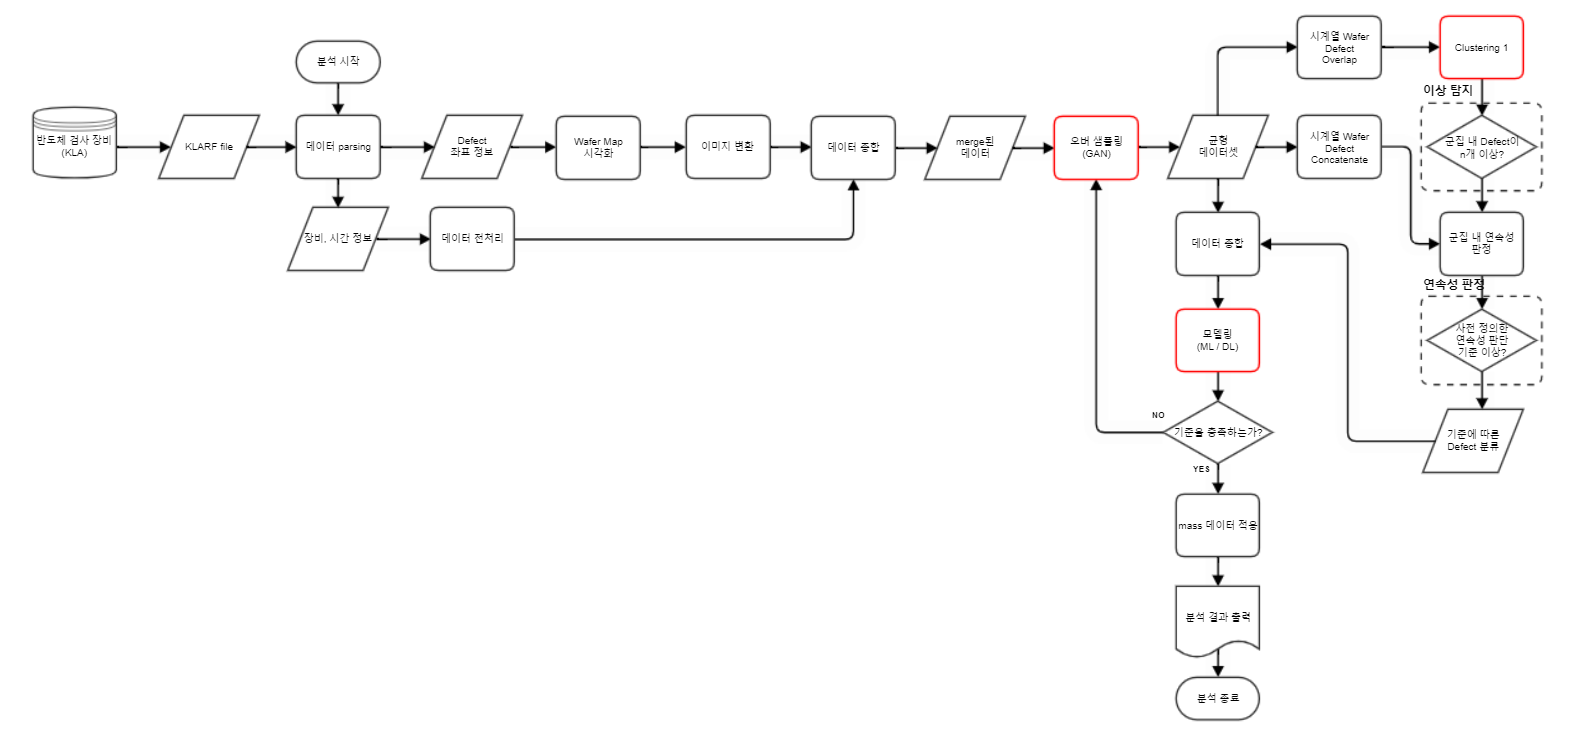

---
## 시작 전...
- python 3.8 version기반으로 팀원 간 동일한 가상환경 구축 완료.
- 각 라이브러리에 대한 버전은 아래에 기술.

*Library Version*

```
anyio==3.5.0
appdirs==1.4.4
argon2-cffi==20.1.0
asttokens==2.0.5
attrs==21.4.0
audioread==3.0.0
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.11.1
bleach==4.1.0
Bottleneck==1.3.5
brotlipy==0.7.0
certifi==2022.12.7
cffi==1.15.1
charset-normalizer==2.0.4
colorama==0.4.6
contourpy==1.0.5
cryptography==38.0.4
cycler==0.11.0
debugpy==1.5.1
decorator==5.1.1
defusedxml==0.7.1
entrypoints==0.4
executing==0.8.3
fastjsonschema==2.15.1
flit_core==3.6.0
fonttools==4.25.0
idna==3.4
importlib-metadata==6.0.0
importlib-resources==5.2.0
ipykernel==6.9.1
ipython==8.4.0
ipython-genutils==0.2.0
ipywidgets==7.6.5
jedi==0.18.1
Jinja2==3.0.3
joblib==1.1.1
json5==0.9.6
jsonschema==4.4.0
jupyter==1.0.0
jupyter-client==7.2.2
jupyter-console==6.4.3
jupyter-core==4.10.0
jupyter-server==1.18.1
jupyterlab==3.4.4
jupyterlab-pygments==0.1.2
jupyterlab-server==2.12.0
jupyterlab-widgets==1.0.0
kiwisolver==1.4.4
librosa==0.9.2
llvmlite==0.39.1
MarkupSafe==2.1.1
matplotlib==3.6.2
matplotlib-inline==0.1.2
mistune==0.8.4
mkl-fft==1.3.1
mkl-random==1.2.2
mkl-service==2.4.0
munkres==1.1.4
nbclassic==0.3.5
nbclient==0.5.13
nbconvert==6.4.4
nbformat==5.3.0
nest-asyncio==1.5.5
notebook==6.4.12
numba==0.56.4
numexpr==2.8.4
numpy==1.22.3
packaging==22.0
pandas==1.5.2
pandocfilters==1.5.0
parso==0.8.3
pexpect==4.8.0
pickleshare==0.7.5
Pillow==9.3.0
pip==22.3.1
ply==3.11
pooch==1.6.0
prometheus-client==0.14.1
prompt-toolkit==3.0.20
ptyprocess==0.7.0
pure-eval==0.2.2
pycparser==2.21
Pygments==2.11.2
pyOpenSSL==22.0.0
pyparsing==3.0.9
PyQt5-sip==12.11.0
pyrsistent==0.18.0
PySocks==1.7.1
python-dateutil==2.8.2
pytz==2022.7
pyzmq==23.2.0
qtconsole==5.3.1
QtPy==2.0.1
requests==2.28.1
resampy==0.4.2
scikit-learn==1.1.3
scipy==1.9.3
seaborn==0.12.1
Send2Trash==1.8.0
setuptools==65.6.3
sip==6.6.2
six==1.16.0
sniffio==1.2.0
soundfile==0.11.0
soupsieve==2.3.1
stack-data==0.2.0
terminado==0.13.1
testpath==0.6.0
threadpoolctl==2.2.0
toml==0.10.2
torch==1.13.1
torchaudio==0.13.1
torchvision==0.14.1
tornado==6.2
tqdm==4.64.1
traitlets==5.1.1
typing_extensions==4.4.0
urllib3==1.26.13
wcwidth==0.2.5
webencodings==0.5.1
websocket-client==0.58.0
wheel==0.37.1
widgetsnbextension==3.5.2
zipp==3.11.0
```

---
## KLARF file parsing

In [171]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import os, sys, glob
from tqdm import tqdm
from datetime import datetime
import re

In [3]:
file_path = glob.glob("klarfsample/*")

len(file_path)

1000

In [4]:
# 실행할 때마다 한 줄씩 읽어오기
# readlines()로 한번에 시도하면, 용량이 큰 파일의 경우엔 out of memory 가능성.

def readfile(file_path):
    readlines = []
    with open(file_path, 'r') as f:
        i = 1
        while True:
            line = f.readline()
            if not line:
                break
            line = str(i) + ' ' + line
            readlines.append(line.strip('\n').strip(';').split(' '))
            i += 1    
    return readlines

readfile(file_path[0])

[['1', 'FileVersion', '1', '1'],
 ['2', 'FileTimestamp', '01-01-23', '21:16:19'],
 ['3', 'TiffSpec', '6.0', 'G', 'R'],
 ['4',
  'InspectionStationID',
  '"ASAC',
  'TECHNOLOGY',
  'INC"',
  '"A3D02"',
  '"A3D02"'],
 ['5', 'SampleType', 'WAFER'],
 ['6', 'ResultTimestamp', '01-01-23', '21:16:19'],
 ['7', 'LotID', '"AS10330WP"'],
 ['8', 'SampleSize', '1', '300'],
 ['9', 'DeviceID', '"AC1"'],
 ['10', 'SetupID', '"Metrology-Type-01"', '01-01-23', '21:16:19'],
 ['11', 'StepID', '"Metrology-Type-01"'],
 ['12', 'SampleOrientationMarkType', 'NOTCH'],
 ['13', 'OrientationMarkLocation', 'DOWN'],
 ['14', 'TiffFilename', 'AS10330WP_AS10330-14_01-01-23_83.tif'],
 ['15', 'DiePitch', '9.308326e+003', '8.178364e+003'],
 ['16', 'DiePitch', '8.000000e+003', '8.000000e+003'],
 ['17', 'WaferID', '', '"14"'],
 ['18', 'Slot', '14'],
 ['19', 'SampleCenterLocation', '0.000', '0.000'],
 ['20', 'InspectionTest', '1'],
 ['21', 'SampleTestPlan', '536'],
 ['22', '18', '26'],
 ['23', '17', '26'],
 ['24', '16', '26']

### KLARF file의 설비, 제품 및 시간에 대한 데이터 parsing

In [5]:
# KLARF file로부터 데이터 parsing
temp_df = pd.DataFrame()
fname = []
for i, fp in enumerate(file_path):
    dict_klarf = {}
    for line in readfile(fp):
        if not line[1].isnumeric():
            dict_klarf[line[1]] = ' '.join(line[2:])
    fname.append(os.path.split(fp)[1].split('.')[0])
    temp = pd.DataFrame(dict_klarf, index=[i])
    temp_df = pd.concat([temp_df, temp])


temp_df['FileName'] = fname
cols = ['FileName']
cols.extend(temp_df.columns[:-1])

temp_df = temp_df[cols]
temp_df.head(3)

,FileName,FileVersion,FileTimestamp,TiffSpec,InspectionStationID,SampleType,ResultTimestamp,LotID,SampleSize,DeviceID,...,Slot,SampleCenterLocation,InspectionTest,SampleTestPlan,AreaPerTest,DefectRecordSpec,DefectList,SummarySpec,SummaryList,EndOfFile
0,AS10330WP_AS10330-14_01-01-23_83,1 1,01-01-23 21:16:19,6.0 G R,"""ASAC TECHNOLOGY INC"" ""A3D02"" ""A3D02""",WAFER,01-01-23 21:16:19,"""AS10330WP""",1 300,"""AC1""",...,14,0.000 0.000,1,536,4.978698e+010,17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE,,
1,AS10103S1_AS10103-14_01-06-23_578,1 1,01-06-23 05:35:07,6.0 G R,"""ASAC TECHNOLOGY INC"" ""A3D02"" ""A3D02""",WAFER,01-06-23 05:35:07,"""AS10103S1""",1 300,"""AS1""",...,14,0.000 0.000,1,536,4.978698e+010,17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE,,
2,AC10022T_AC10022-02_01-07-23_780,1 1,01-07-23 23:14:07,6.0 G R,"""ASAC TECHNOLOGY INC"" ""A3D01"" ""A3D01""",WAFER,01-07-23 23:14:07,"""AC10022T""",1 300,"""AC1""",...,02,0.000 0.000,1,536,4.978698e+010,17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE,,


In [6]:
# unique값이 1인 columns 정리
singleCols = []
for col in temp_df.columns:
    if len(temp_df[col].unique()) == 1:
        singleCols.append(col)
        print('==='*20)
        print(col)
        print(temp_df[col].unique())
    
# 위에서 정리한 columns에 이미 dataframe으로 만든 DefectList, SummaryList columns 추가
singleCols.extend(["DefectList", "SummaryList"])
singleCols

FileVersion
['1 1']
TiffSpec
['6.0 G R']
SampleType
['WAFER']
SampleSize
['1 300']
SampleOrientationMarkType
['NOTCH']
OrientationMarkLocation
['DOWN']
DiePitch
['8.000000e+003 8.000000e+003']
SampleCenterLocation
['0.000 0.000']
InspectionTest
['1']
SampleTestPlan
['536']
AreaPerTest
['4.978698e+010']
DefectRecordSpec
['17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZE DEFECTAREA DSIZE CLASSNUMBER TEST CLUSTERNUMBER ROUGHBINNUMBER FINEBINNUMBER REVIEWSAMPLE IMAGECOUNT IMAGELIST']
DefectList
['']
SummarySpec
['5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE']
SummaryList
['']
EndOfFile
['']


['FileVersion',
 'TiffSpec',
 'SampleType',
 'SampleSize',
 'SampleOrientationMarkType',
 'OrientationMarkLocation',
 'DiePitch',
 'SampleCenterLocation',
 'InspectionTest',
 'SampleTestPlan',
 'AreaPerTest',
 'DefectRecordSpec',
 'DefectList',
 'SummarySpec',
 'SummaryList',
 'EndOfFile',
 'DefectList',
 'SummaryList']

In [7]:
# 단일 원소를 가진 columns 제거.
temp_df.drop(columns=singleCols, inplace=True)

In [8]:
# column 비교 후 제거 함수
# 보존할 column = col1
# 제거할 column = col2
def eliminate(df, col1, col2):
    '''
    col1: 남길 컬럼
    col2: 제거할 컬럼
    '''
    if df[df[col1] != df[col2]].size == 0:
        df.drop(columns=col2, inplace=True)
        print(f'"{col2}" Column 제거됨.')
    return df

# FileTimestamp column과 ResultTimestamp column이 동일하면 해당 컬럼 삭제
temp_df = eliminate(temp_df, "FileTimestamp", "ResultTimestamp")
temp_df.head(3)

"ResultTimestamp" Column 제거됨.


,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,SetupID,StepID,TiffFilename,WaferID,Slot
0,AS10330WP_AS10330-14_01-01-23_83,01-01-23 21:16:19,"""ASAC TECHNOLOGY INC"" ""A3D02"" ""A3D02""","""AS10330WP""","""AC1""","""Metrology-Type-01"" 01-01-23 21:16:19","""Metrology-Type-01""",AS10330WP_AS10330-14_01-01-23_83.tif,"""14""",14
1,AS10103S1_AS10103-14_01-06-23_578,01-06-23 05:35:07,"""ASAC TECHNOLOGY INC"" ""A3D02"" ""A3D02""","""AS10103S1""","""AS1""","""Metrology-Type-01"" 01-06-23 05:35:07","""Metrology-Type-01""",AS10103S1_AS10103-14_01-06-23_578.tif,"""14""",14
2,AC10022T_AC10022-02_01-07-23_780,01-07-23 23:14:07,"""ASAC TECHNOLOGY INC"" ""A3D01"" ""A3D01""","""AC10022T""","""AC1""","""Metrology-Type-02"" 01-07-23 23:14:07","""Metrology-Type-02""",AC10022T_AC10022-02_01-07-23_780.tif,"""02""",02


In [9]:
# temp_df의 FileTimestamp를 datetime형으로 변환
# 현재 %m-%d-%y %H:%M:%S 형태로 되어있음. 이를 %Y-%m-%d %H:%M:%S

temp_df.FileTimestamp = temp_df.FileTimestamp.apply(lambda x: datetime.strptime(x, "%m-%d-%y %H:%M:%S"))
temp_df.head(3)

,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,SetupID,StepID,TiffFilename,WaferID,Slot
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,"""ASAC TECHNOLOGY INC"" ""A3D02"" ""A3D02""","""AS10330WP""","""AC1""","""Metrology-Type-01"" 01-01-23 21:16:19","""Metrology-Type-01""",AS10330WP_AS10330-14_01-01-23_83.tif,"""14""",14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,"""ASAC TECHNOLOGY INC"" ""A3D02"" ""A3D02""","""AS10103S1""","""AS1""","""Metrology-Type-01"" 01-06-23 05:35:07","""Metrology-Type-01""",AS10103S1_AS10103-14_01-06-23_578.tif,"""14""",14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,"""ASAC TECHNOLOGY INC"" ""A3D01"" ""A3D01""","""AC10022T""","""AC1""","""Metrology-Type-02"" 01-07-23 23:14:07","""Metrology-Type-02""",AC10022T_AC10022-02_01-07-23_780.tif,"""02""",02


In [10]:
# InspectionStationID column
print(temp_df.InspectionStationID.unique())

# A3D01, A3D02로 요약할 수 있음.
temp_df.InspectionStationID = temp_df.InspectionStationID.apply(lambda x: x.strip('"').split('" "')[-1])
temp_df.head(3)

['"ASAC TECHNOLOGY INC" "A3D02" "A3D02"'
 '"ASAC TECHNOLOGY INC" "A3D01" "A3D01"']


,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,SetupID,StepID,TiffFilename,WaferID,Slot
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,"""AS10330WP""","""AC1""","""Metrology-Type-01"" 01-01-23 21:16:19","""Metrology-Type-01""",AS10330WP_AS10330-14_01-01-23_83.tif,"""14""",14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,"""AS10103S1""","""AS1""","""Metrology-Type-01"" 01-06-23 05:35:07","""Metrology-Type-01""",AS10103S1_AS10103-14_01-06-23_578.tif,"""14""",14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,"""AC10022T""","""AC1""","""Metrology-Type-02"" 01-07-23 23:14:07","""Metrology-Type-02""",AC10022T_AC10022-02_01-07-23_780.tif,"""02""",02


In [11]:
# "LotID", "DeviceID", "StepID", "WaferID" columns에 대해 " " 제거
temp_df[["LotID", "DeviceID", "StepID", "WaferID"]] = \
    temp_df[["LotID", "DeviceID", "StepID", "WaferID"]].applymap(lambda x: x.strip(' "'))
temp_df.head(3)

,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,SetupID,StepID,TiffFilename,WaferID,Slot
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,"""Metrology-Type-01"" 01-01-23 21:16:19",Metrology-Type-01,AS10330WP_AS10330-14_01-01-23_83.tif,14,14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,"""Metrology-Type-01"" 01-06-23 05:35:07",Metrology-Type-01,AS10103S1_AS10103-14_01-06-23_578.tif,14,14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,"""Metrology-Type-02"" 01-07-23 23:14:07",Metrology-Type-02,AC10022T_AC10022-02_01-07-23_780.tif,02,02


In [12]:
# WaferID column과 Slot column이 동일한지 확인.
# 동일하면 Slot column 제거
# 동일하지 않다면, Fab에 문제가 생긴것..

temp_df = eliminate(temp_df, "WaferID", "Slot")
temp_df.head(3)

"Slot" Column 제거됨.


,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,SetupID,StepID,TiffFilename,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,"""Metrology-Type-01"" 01-01-23 21:16:19",Metrology-Type-01,AS10330WP_AS10330-14_01-01-23_83.tif,14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,"""Metrology-Type-01"" 01-06-23 05:35:07",Metrology-Type-01,AS10103S1_AS10103-14_01-06-23_578.tif,14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,"""Metrology-Type-02"" 01-07-23 23:14:07",Metrology-Type-02,AC10022T_AC10022-02_01-07-23_780.tif,02


In [13]:
# SetupID column
print(temp_df.SetupID.apply(lambda x: x.split('"')[1]).unique())
print('\n')
print(temp_df.SetupID.apply(lambda x: x.split('"')[2].strip(' ')).unique())

['Metrology-Type-01' 'Metrology-Type-02' 'Metrology-type-01'
 'Metrology-type-02']


['01-01-23 21:16:19' '01-06-23 05:35:07' '01-07-23 23:14:07'
 '01-07-23 13:00:32' '01-03-23 17:10:56' '01-01-23 23:39:26'
 '01-05-23 20:58:20' '01-02-23 11:14:42' '01-04-23 09:31:06'
 '01-08-23 06:02:34' '01-05-23 02:52:45' '01-08-23 07:13:48'
 '01-06-23 19:15:35' '01-03-23 11:48:45' '01-02-23 02:12:27'
 '01-08-23 12:17:32' '01-06-23 01:39:41' '01-06-23 14:53:05'
 '01-02-23 02:13:50' '01-06-23 02:00:19' '01-01-23 05:55:43'
 '01-07-23 10:01:50' '01-06-23 08:51:49' '01-07-23 11:15:30'
 '01-09-23 10:59:35' '01-08-23 05:11:06' '01-08-23 02:59:23'
 '01-06-23 21:09:51' '01-03-23 04:36:38' '01-03-23 00:13:22'
 '01-05-23 17:10:00' '01-06-23 18:00:23' '01-06-23 01:07:54'
 '01-09-23 13:44:16' '01-09-23 11:37:19' '01-02-23 12:43:30'
 '01-03-23 19:30:19' '01-03-23 23:14:39' '01-06-23 04:20:11'
 '01-08-23 10:01:42' '01-01-23 23:16:24' '01-05-23 16:04:33'
 '01-07-23 09:40:56' '01-02-23 03:02:27' '01-04-23 05:21:27'


In [14]:
# SetupID column에서 timestamp가 FileTimestamp와 일치하는지 확인.
# 완벽히 일치한다면 해당 timestamp만 제거.
if temp_df[temp_df.SetupID.apply(lambda x: datetime.strptime(x.split('"')[2].strip(' '), "%m-%d-%y %H:%M:%S"))
        != temp_df.FileTimestamp].size == 0:
    temp_df.SetupID = temp_df.SetupID.apply(lambda x: x.split('"')[1])
    print('timestamp 제거됨.')
temp_df.head(3)

timestamp 제거됨.


,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,SetupID,StepID,TiffFilename,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,Metrology-Type-01,Metrology-Type-01,AS10330WP_AS10330-14_01-01-23_83.tif,14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,Metrology-Type-01,Metrology-Type-01,AS10103S1_AS10103-14_01-06-23_578.tif,14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,Metrology-Type-02,Metrology-Type-02,AC10022T_AC10022-02_01-07-23_780.tif,02


In [15]:
# 수정된 SetupID column에서 Metrology-Type이 StepID와 일치하는지 확인.
# 완벽히 일치한다면 해당 column 제거.
temp_df = eliminate(temp_df, 'StepID', 'SetupID')
temp_df.head(3)

"SetupID" Column 제거됨.


,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,StepID,TiffFilename,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,Metrology-Type-01,AS10330WP_AS10330-14_01-01-23_83.tif,14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,Metrology-Type-01,AS10103S1_AS10103-14_01-06-23_578.tif,14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,Metrology-Type-02,AC10022T_AC10022-02_01-07-23_780.tif,02


In [16]:
# StepID column 종류 확인.
temp_df.StepID.unique()

array(['Metrology-Type-01', 'Metrology-Type-02', 'Metrology-type-01',
       'Metrology-type-02'], dtype=object)

In [17]:
# StepID의 column 통일
temp_df.StepID = temp_df.StepID.apply(lambda x: x.split('-')[0]
                                      + '-T' + x.split('-')[1][1:]
                                      + '-' + x.split('-')[2])
temp_df.head(3)

,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,StepID,TiffFilename,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,Metrology-Type-01,AS10330WP_AS10330-14_01-01-23_83.tif,14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,Metrology-Type-01,AS10103S1_AS10103-14_01-06-23_578.tif,14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,Metrology-Type-02,AC10022T_AC10022-02_01-07-23_780.tif,02


In [18]:
# TiffFilename column이 FileName column과 일치하면 제거.
temp_df[["FileName", "TiffFilename"]] = temp_df[["FileName", "TiffFilename"]].applymap(lambda x: x.split('.')[0])
temp_df = eliminate(temp_df, "FileName", "TiffFilename")
temp_df.head(3)

"TiffFilename" Column 제거됨.


,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,StepID,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,Metrology-Type-01,14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,Metrology-Type-01,14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,Metrology-Type-02,02


In [19]:
# WaferID에 LotID 정보 추가
temp_df.WaferID = temp_df.LotID.apply(lambda x: re.split('\d+', x)[0]+re.split('\D+', x)[1]) + '-' + temp_df.WaferID
temp_df.head(3)

,FileName,FileTimestamp,InspectionStationID,LotID,DeviceID,StepID,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,Metrology-Type-01,AS10330-14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,Metrology-Type-01,AS10103-14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,Metrology-Type-02,AC10022-02


In [20]:
# columns 이름 변경
# FileTimestamp -> Timestamp
# InspectionStationID -> MachineID
temp_df.rename(columns={'FileTimestamp': 'Timestamp',
                        'InspectionStationID': 'MachineID'}, inplace=True)
temp_df.head(3)

,FileName,Timestamp,MachineID,LotID,DeviceID,StepID,WaferID
0,AS10330WP_AS10330-14_01-01-23_83,2023-01-01 21:16:19,A3D02,AS10330WP,AC1,Metrology-Type-01,AS10330-14
1,AS10103S1_AS10103-14_01-06-23_578,2023-01-06 05:35:07,A3D02,AS10103S1,AS1,Metrology-Type-01,AS10103-14
2,AC10022T_AC10022-02_01-07-23_780,2023-01-07 23:14:07,A3D01,AC10022T,AC1,Metrology-Type-02,AC10022-02


In [21]:
# columns 순서 변경
newcols = ['FileName', 'LotID', 'WaferID', 'Timestamp', 'MachineID', 'StepID', 'DeviceID']
temp_df = temp_df[newcols]
temp_df.head(3)

,FileName,LotID,WaferID,Timestamp,MachineID,StepID,DeviceID
0,AS10330WP_AS10330-14_01-01-23_83,AS10330WP,AS10330-14,2023-01-01 21:16:19,A3D02,Metrology-Type-01,AC1
1,AS10103S1_AS10103-14_01-06-23_578,AS10103S1,AS10103-14,2023-01-06 05:35:07,A3D02,Metrology-Type-01,AS1
2,AC10022T_AC10022-02_01-07-23_780,AC10022T,AC10022-02,2023-01-07 23:14:07,A3D01,Metrology-Type-02,AC1


In [22]:
# timestamp 순으로 정렬
temp_df = temp_df.sort_values('Timestamp').reset_index(drop=True)
temp_df

,FileName,LotID,WaferID,Timestamp,MachineID,StepID,DeviceID
0,AC10002SA_AC10002-01_01-01-23_1,AC10002SA,AC10002-01,2023-01-01 04:10:00,A3D02,Metrology-Type-01,AC1
1,AS10001T_AS10001-01_01-01-23_2,AS10001T,AS10001-01,2023-01-01 04:12:49,A3D01,Metrology-Type-01,AS1
2,AS10001T_AS10001-02_01-01-23_3,AS10001T,AS10001-02,2023-01-01 04:38:19,A3D01,Metrology-Type-01,AS1
3,AC10002SA_AC10002-03_01-01-23_4,AC10002SA,AC10002-03,2023-01-01 04:41:51,A3D02,Metrology-Type-01,AC1
4,AS10001T_AS10001-03_01-01-23_5,AS10001T,AS10001-03,2023-01-01 04:55:52,A3D01,Metrology-Type-01,AS1
...,...,...,...,...,...,...,...
995,AC10358SP_AC10358-21_01-10-23_996,AC10358SP,AC10358-21,2023-01-10 00:42:47,A3D01,Metrology-Type-01,AC1
996,AC10358SP_AC10358-22_01-10-23_997,AC10358SP,AC10358-22,2023-01-10 01:12:48,A3D01,Metrology-Type-01,AC1
997,AC10358SP_AC10358-23_01-10-23_998,AC10358SP,AC10358-23,2023-01-10 01:40:57,A3D01,Metrology-Type-01,AC1
998,AC10358SP_AC10358-24_01-10-23_999,AC10358SP,AC10358-24,2023-01-10 02:13:23,A3D01,Metrology-Type-01,AC1


### Wafer Map Visuallization

In [23]:
# Wafer Map Frame을 생성하기 위한 좌표 추출
readlines = readfile(file_path[0])
for line in readlines:
    if line[1] == 'SampleTestPlan':
        firstRow = int(line[0])
        print(f'firstRow: {firstRow}')
    elif line[1] == 'AreaPerTest':
        lastRow = int(line[0]) - 2
        print(f'lastRow: {lastRow}')
        
wafer_x_coordinate = [int(line[1]) for line in readlines[firstRow:lastRow+1]]
wafer_y_coordinate = [int(line[2]) for line in readlines[firstRow:lastRow+1]]

print(f'x_min: {min(wafer_x_coordinate)}, x_max: {max(wafer_x_coordinate)}')
print(f'y_min: {min(wafer_y_coordinate)}, y_max: {max(wafer_y_coordinate)}')

firstRow: 21
lastRow: 556
x_min: 1, x_max: 24
y_min: 1, y_max: 26


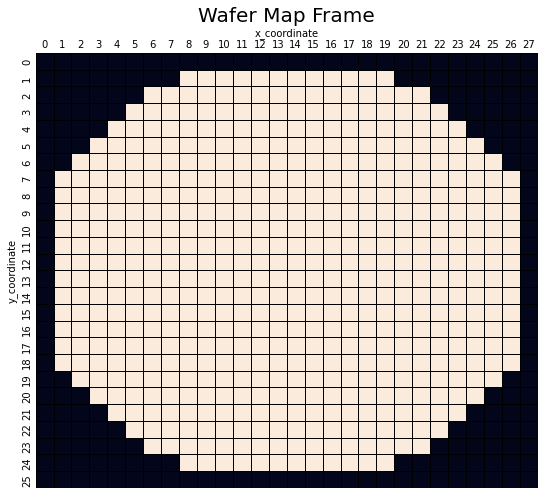

In [24]:
base_wafer = np.zeros([max(wafer_x_coordinate)+2, max(wafer_y_coordinate)+2])
for x,y in zip(wafer_x_coordinate, wafer_y_coordinate):
    base_wafer[x,y] = 1

def visualization_wafer(map, size, title):
    plt.figure(figsize=(size+1,size))
    ax = sns.heatmap(map, linewidths=1, linecolor='black', cbar=False)
    plt.xlabel("x_coordinate")
    plt.ylabel("y_coordinate")
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    plt.title(title, fontsize=20)
    plt.show()
    
visualization_wafer(base_wafer, 8, "Wafer Map Frame")

In [25]:
# DefectList를 dataframe으로 변환.
defectList = []
for fp in tqdm(file_path):
    readlines = readfile(fp)
    for line in readlines:
        if line[1] == 'DefectList':
            defectRow = int(line[0])
        elif line[1] == 'SummarySpec':
            defectRowEND = int(line[0]) - 1
        else:
            continue
        
    defectCols = ['FILE']
    defectCols.extend(readlines[defectRow-2][3:])
    
    if readlines[defectRow][1].isnumeric():
        for line in readlines[defectRow:defectRowEND]:
            if len(line) == 18:
                temp = [os.path.split(fp)[1]]
                temp.extend(line[1:])
                defectList.append(temp)
    else:
        temp = [os.path.split(fp)[1]]
        temp.extend(np.zeros(17).tolist())
        defectList.append(temp)

temp_defectDF = pd.DataFrame(data=defectList, columns=defectCols)
temp_defectDF[["XINDEX", "YINDEX"]] = temp_defectDF[["XINDEX", "YINDEX"]].astype('int')
temp_defectDF

100%|██████████| 1000/1000 [00:00<00:00, 4134.80it/s]


,FILE,DEFECTID,XREL,YREL,XINDEX,YINDEX,XSIZE,YSIZE,DEFECTAREA,DSIZE,CLASSNUMBER,TEST,CLUSTERNUMBER,ROUGHBINNUMBER,FINEBINNUMBER,REVIEWSAMPLE,IMAGECOUNT,IMAGELIST
0,AS10330WP_AS10330-14_01-01-23_83.001,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AS10103S1_AS10103-14_01-06-23_578.001,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AC10022T_AC10022-02_01-07-23_780.001,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AS10016TK_AS10016-17_01-07-23_731.001,1,1.5e+01,2.826e+03,2,1,499.077,502.606,0,0.000000,232,1,0,100,0,0,2,2
4,AC10010S1_AC10010-07_01-03-23_297.001,1,5.98e+03,5.289e+03,8,2,506.242,488.036,0,0.000000,232,1,0,100,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,AC10002SA_AC10002-01_01-01-23_1.001,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1316,AC10002SA_AC10002-21_01-01-23_21.001,1,7.75e+02,2.07e+03,13,15,529.648,520.685,0,0.000000,232,1,0,100,0,0,2,2
1317,AC10002SA_AC10002-21_01-01-23_21.001,1,5.949e+03,3.836e+03,10,5,491.581,516.865,0,0.000000,232,1,0,100,0,0,2,2
1318,AS20010SS_AS20010-12_01-02-23_179.001,1,5.425e+03,9.87e+02,17,16,494.287,489.669,0,0.000000,232,1,0,100,0,0,2,2


In [26]:
# Summary Spec.을 DataFrame으로 변환

summarySpec = []
for fp in tqdm(file_path):
    readlines = readfile(fp)
    for line in readlines:
        if line[1] == 'SummarySpec':
            summaryRow = int(line[0])
            
    summaryCols = ['FILE']
    summaryCols.extend(readlines[summaryRow-1][3:])
    if readlines[summaryRow+1][1].isnumeric():
        temp = [os.path.split(fp)[1]]
        temp.extend(readlines[summaryRow+1][1:])
        summarySpec.append(temp)
    else:
        temp = [os.path.split(fp)[1]]
        temp.extend(np.zeros(5).tolist())
        summarySpec.append(temp)

summary_df = pd.DataFrame(data=summarySpec, columns=summaryCols, index=np.arange(1000))
summary_df

100%|██████████| 1000/1000 [00:00<00:00, 4295.91it/s]


,FILE,TESTNO,NDEFECT,DEFDENSITY,NDIE,NDEFDIE
0,AS10330WP_AS10330-14_01-01-23_83.001,1,0,1.000,536,0
1,AS10103S1_AS10103-14_01-06-23_578.001,1,0,1.000,536,0
2,AC10022T_AC10022-02_01-07-23_780.001,1,0,1.000,536,0
3,AS10016TK_AS10016-17_01-07-23_731.001,1,1,1.000,535,1
4,AC10010S1_AC10010-07_01-03-23_297.001,1,1,1.000,535,1
...,...,...,...,...,...,...
995,AS10038T1_AS10038-15_01-07-23_704.001,1,1,1.000,535,1
996,AC10002SA_AC10002-01_01-01-23_1.001,1,0,1.000,536,0
997,AC10002SA_AC10002-21_01-01-23_21.001,1,2,1.000,534,2
998,AS20010SS_AS20010-12_01-02-23_179.001,1,1,1.000,535,1


In [27]:
# defect_df와 summary_df merge
defect_df = pd.merge(summary_df, temp_defectDF, how='inner', left_on='FILE', right_on='FILE')
defect_df

,FILE,TESTNO,NDEFECT,DEFDENSITY,NDIE,NDEFDIE,DEFECTID,XREL,YREL,XINDEX,...,DEFECTAREA,DSIZE,CLASSNUMBER,TEST,CLUSTERNUMBER,ROUGHBINNUMBER,FINEBINNUMBER,REVIEWSAMPLE,IMAGECOUNT,IMAGELIST
0,AS10330WP_AS10330-14_01-01-23_83.001,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AS10103S1_AS10103-14_01-06-23_578.001,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AC10022T_AC10022-02_01-07-23_780.001,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AS10016TK_AS10016-17_01-07-23_731.001,1,1,1.000,535,1,1,1.5e+01,2.826e+03,2,...,0,0.000000,232,1,0,100,0,0,2,2
4,AC10010S1_AC10010-07_01-03-23_297.001,1,1,1.000,535,1,1,5.98e+03,5.289e+03,8,...,0,0.000000,232,1,0,100,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,AC10002SA_AC10002-01_01-01-23_1.001,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1316,AC10002SA_AC10002-21_01-01-23_21.001,1,2,1.000,534,2,1,7.75e+02,2.07e+03,13,...,0,0.000000,232,1,0,100,0,0,2,2
1317,AC10002SA_AC10002-21_01-01-23_21.001,1,2,1.000,534,2,1,5.949e+03,3.836e+03,10,...,0,0.000000,232,1,0,100,0,0,2,2
1318,AS20010SS_AS20010-12_01-02-23_179.001,1,1,1.000,535,1,1,5.425e+03,9.87e+02,17,...,0,0.000000,232,1,0,100,0,0,2,2


In [28]:
# defect_df의 FILE columns 변경
defect_df.FILE = defect_df.FILE.apply(lambda x: x.split('.')[0])

In [29]:
defect_df.NDEFECT.isna().sum()

0

In [30]:
defect_df.NDEFECT.unique()

array(['0', '1', '2'], dtype=object)

In [31]:
defect_df.DEFECTID.unique()

array([0.0, '1'], dtype=object)

In [32]:
defect_df.CLASSNUMBER.unique()

array([0.0, '232'], dtype=object)

In [33]:
defect_df[defect_df.NDEFECT == '2']

,FILE,TESTNO,NDEFECT,DEFDENSITY,NDIE,NDEFDIE,DEFECTID,XREL,YREL,XINDEX,...,DEFECTAREA,DSIZE,CLASSNUMBER,TEST,CLUSTERNUMBER,ROUGHBINNUMBER,FINEBINNUMBER,REVIEWSAMPLE,IMAGECOUNT,IMAGELIST
8,AC10002WE_AC10002-23_01-02-23_151,1,2,1.000,534,2,1,3.735e+03,6.346e+03,4,...,0,0.000000,232,1,0,100,0,0,2,2
9,AC10002WE_AC10002-23_01-02-23_151,1,2,1.000,534,2,1,3.667e+03,4.73e+02,15,...,0,0.000000,232,1,0,100,0,0,2,2
12,AS10051TP_AS10051-01_01-05-23_451,1,2,1.000,534,2,1,5.19e+03,5.224e+03,10,...,0,0.000000,232,1,0,100,0,0,2,2
13,AS10051TP_AS10051-01_01-05-23_451,1,2,1.000,534,2,1,6.909e+03,2.739e+03,9,...,0,0.000000,232,1,0,100,0,0,2,2
16,AC20077T_AC20077-07_01-03-23_269,1,2,1.000,534,2,1,5.035e+03,5.791e+03,17,...,0,0.000000,232,1,0,100,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,AS11333SS_AS11333-16_01-09-23_911,1,2,1.000,534,2,1,7.69e+03,5.418e+03,3,...,0,0.000000,232,1,0,100,0,0,2,2
1310,AC10002SA_AC10002-05_01-01-23_6,1,2,1.000,534,2,1,3.93e+02,6.791e+03,17,...,0,0.000000,232,1,0,100,0,0,2,2
1311,AC10002SA_AC10002-05_01-01-23_6,1,2,1.000,534,2,1,6.68e+02,2.15e+03,22,...,0,0.000000,232,1,0,100,0,0,2,2
1316,AC10002SA_AC10002-21_01-01-23_21,1,2,1.000,534,2,1,7.75e+02,2.07e+03,13,...,0,0.000000,232,1,0,100,0,0,2,2


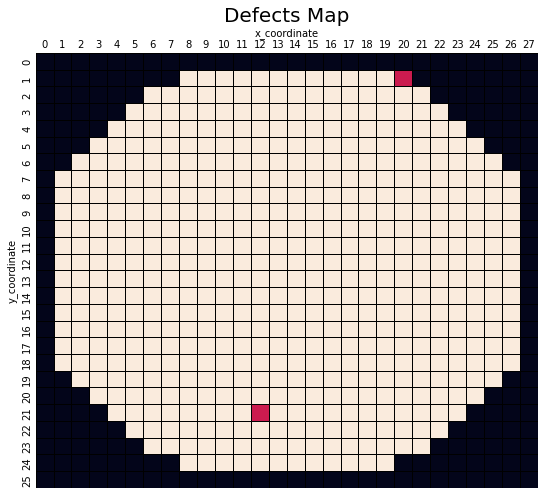

In [34]:
# defect 시각화
defectMaps=[]
for fp in file_path:
    base = base_wafer.copy()
    filename = os.path.split(fp)[1]
    defect_x = defect_df[defect_df.FILE == filename.split('.')[0]][["XINDEX"]].astype('int').values
    defect_y = defect_df[defect_df.FILE == filename.split('.')[0]][["YINDEX"]].astype('int').values
    
    if (defect_x == 0).all():
        pass
    else:
        for i in range(defect_x.size):
            base[defect_x[i][0], defect_y[i][0]] = 0.5
    defectMaps.append(base)
    
# 임의의 defect map 시각화
visualization_wafer(defectMaps[55],8, "Defects Map")

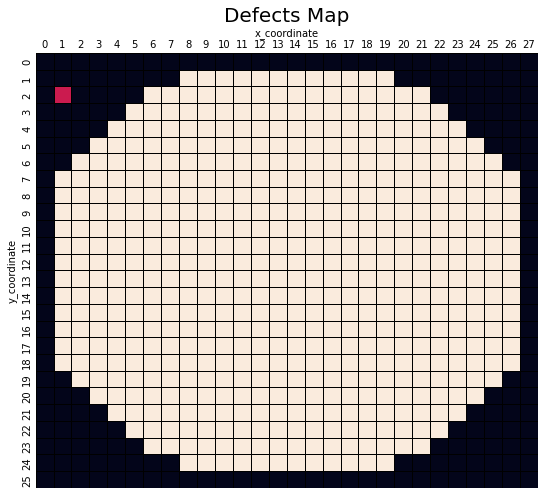

In [35]:
# defect가 wafer 영역 밖에서 표현되는 경우가 존재.
visualization_wafer(defectMaps[3],8, "Defects Map")

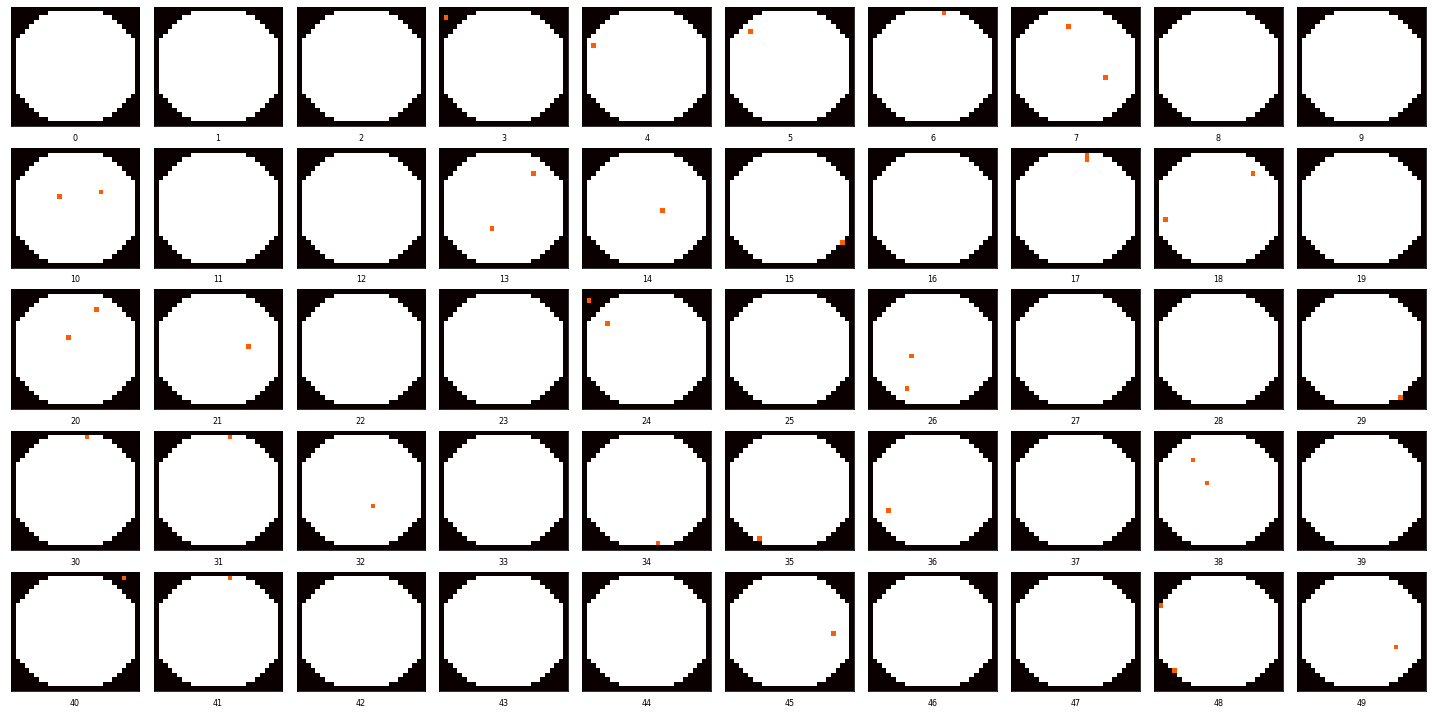

In [36]:
# 다중 wafer 시각화 (단순 추이를 보기 위함.)
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(20,10))
ax = ax.ravel(order='C')
for i in range(50):
    ax[i].imshow(defectMaps[i], cmap=cm.hot)
    ax[i].set_xlabel(f'{i}', fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

## 분석을 위한 데이터프레임 생성

- 시계열 특성을 고려하여 dataframe 생성
1. WaferID
2. MachineID
3. StepID
4. DeviceID  

위 컬럼을 기준으로 4개의 dataframe 생성함.

In [37]:
temp_df

,FileName,LotID,WaferID,Timestamp,MachineID,StepID,DeviceID
0,AC10002SA_AC10002-01_01-01-23_1,AC10002SA,AC10002-01,2023-01-01 04:10:00,A3D02,Metrology-Type-01,AC1
1,AS10001T_AS10001-01_01-01-23_2,AS10001T,AS10001-01,2023-01-01 04:12:49,A3D01,Metrology-Type-01,AS1
2,AS10001T_AS10001-02_01-01-23_3,AS10001T,AS10001-02,2023-01-01 04:38:19,A3D01,Metrology-Type-01,AS1
3,AC10002SA_AC10002-03_01-01-23_4,AC10002SA,AC10002-03,2023-01-01 04:41:51,A3D02,Metrology-Type-01,AC1
4,AS10001T_AS10001-03_01-01-23_5,AS10001T,AS10001-03,2023-01-01 04:55:52,A3D01,Metrology-Type-01,AS1
...,...,...,...,...,...,...,...
995,AC10358SP_AC10358-21_01-10-23_996,AC10358SP,AC10358-21,2023-01-10 00:42:47,A3D01,Metrology-Type-01,AC1
996,AC10358SP_AC10358-22_01-10-23_997,AC10358SP,AC10358-22,2023-01-10 01:12:48,A3D01,Metrology-Type-01,AC1
997,AC10358SP_AC10358-23_01-10-23_998,AC10358SP,AC10358-23,2023-01-10 01:40:57,A3D01,Metrology-Type-01,AC1
998,AC10358SP_AC10358-24_01-10-23_999,AC10358SP,AC10358-24,2023-01-10 02:13:23,A3D01,Metrology-Type-01,AC1


In [38]:
defect_df = defect_df.assign(MAP=lambda x: x.XINDEX.astype('str') + ' ' + x.YINDEX.astype('str'))
defect_df

,FILE,TESTNO,NDEFECT,DEFDENSITY,NDIE,NDEFDIE,DEFECTID,XREL,YREL,XINDEX,...,DSIZE,CLASSNUMBER,TEST,CLUSTERNUMBER,ROUGHBINNUMBER,FINEBINNUMBER,REVIEWSAMPLE,IMAGECOUNT,IMAGELIST,MAP
0,AS10330WP_AS10330-14_01-01-23_83,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 0
1,AS10103S1_AS10103-14_01-06-23_578,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 0
2,AC10022T_AC10022-02_01-07-23_780,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 0
3,AS10016TK_AS10016-17_01-07-23_731,1,1,1.000,535,1,1,1.5e+01,2.826e+03,2,...,0.000000,232,1,0,100,0,0,2,2,2 1
4,AC10010S1_AC10010-07_01-03-23_297,1,1,1.000,535,1,1,5.98e+03,5.289e+03,8,...,0.000000,232,1,0,100,0,0,2,2,8 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,AC10002SA_AC10002-01_01-01-23_1,1,0,1.000,536,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 0
1316,AC10002SA_AC10002-21_01-01-23_21,1,2,1.000,534,2,1,7.75e+02,2.07e+03,13,...,0.000000,232,1,0,100,0,0,2,2,13 15
1317,AC10002SA_AC10002-21_01-01-23_21,1,2,1.000,534,2,1,5.949e+03,3.836e+03,10,...,0.000000,232,1,0,100,0,0,2,2,10 5
1318,AS20010SS_AS20010-12_01-02-23_179,1,1,1.000,535,1,1,5.425e+03,9.87e+02,17,...,0.000000,232,1,0,100,0,0,2,2,17 16


In [43]:
defect_temp = defect_df.groupby(['FILE'])["MAP"].apply(','.join).reset_index()
defect_temp.MAP = defect_temp.MAP.apply(lambda x: x.split(','))
defect_temp

,FILE,MAP
0,AC10001TA_AC10001-01_01-01-23_41,[24 20]
1,AC10001TA_AC10001-02_01-01-23_43,[15 17]
2,AC10001TA_AC10001-03_01-01-23_45,[0 0]
3,AC10001TA_AC10001-04_01-01-23_47,[0 0]
4,AC10001TA_AC10001-05_01-01-23_49,[16 21]
...,...,...
995,AS20300S_AS20300-21_01-07-23_690,[0 0]
996,AS20300S_AS20300-22_01-07-23_692,[0 0]
997,AS20300S_AS20300-23_01-07-23_693,[8 5]
998,AS20300S_AS20300-24_01-07-23_695,[0 0]


In [44]:
df = pd.merge(temp_df, defect_temp, how='inner', left_on='FileName', right_on='FILE').drop(columns=["FILE", "FileName"])
df

,LotID,WaferID,Timestamp,MachineID,StepID,DeviceID,MAP
0,AC10002SA,AC10002-01,2023-01-01 04:10:00,A3D02,Metrology-Type-01,AC1,[0 0]
1,AS10001T,AS10001-01,2023-01-01 04:12:49,A3D01,Metrology-Type-01,AS1,[16 15]
2,AS10001T,AS10001-02,2023-01-01 04:38:19,A3D01,Metrology-Type-01,AS1,[0 0]
3,AC10002SA,AC10002-03,2023-01-01 04:41:51,A3D02,Metrology-Type-01,AC1,[0 0]
4,AS10001T,AS10001-03,2023-01-01 04:55:52,A3D01,Metrology-Type-01,AS1,[0 0]
...,...,...,...,...,...,...,...
995,AC10358SP,AC10358-21,2023-01-10 00:42:47,A3D01,Metrology-Type-01,AC1,[11 20]
996,AC10358SP,AC10358-22,2023-01-10 01:12:48,A3D01,Metrology-Type-01,AC1,[3 18]
997,AC10358SP,AC10358-23,2023-01-10 01:40:57,A3D01,Metrology-Type-01,AC1,"[24 5, 12 4]"
998,AC10358SP,AC10358-24,2023-01-10 02:13:23,A3D01,Metrology-Type-01,AC1,[9 14]


<h3>LotID 기준</h3>

- 동일 LotID로 그룹화

In [45]:
lot_df = df.sort_values(['LotID','Timestamp']).reset_index(drop=True)
lot_df

,LotID,WaferID,Timestamp,MachineID,StepID,DeviceID,MAP
0,AC10001TA,AC10001-01,2023-01-01 12:48:02,A3D01,Metrology-Type-01,AC1,[24 20]
1,AC10001TA,AC10001-02,2023-01-01 13:07:32,A3D01,Metrology-Type-01,AC1,[15 17]
2,AC10001TA,AC10001-03,2023-01-01 13:38:36,A3D01,Metrology-Type-01,AC1,[0 0]
3,AC10001TA,AC10001-04,2023-01-01 13:55:29,A3D01,Metrology-Type-01,AC1,[0 0]
4,AC10001TA,AC10001-05,2023-01-01 14:15:04,A3D01,Metrology-Type-01,AC1,[16 21]
...,...,...,...,...,...,...,...
995,AS20300S,AS20300-21,2023-01-07 04:22:43,A3D02,Metrology-Type-01,AC2,[0 0]
996,AS20300S,AS20300-22,2023-01-07 04:45:06,A3D02,Metrology-Type-01,AC2,[0 0]
997,AS20300S,AS20300-23,2023-01-07 05:01:53,A3D02,Metrology-Type-01,AC2,[8 5]
998,AS20300S,AS20300-24,2023-01-07 05:19:38,A3D02,Metrology-Type-01,AC2,[0 0]


In [100]:
base_wafer = np.zeros([max(wafer_x_coordinate)+2, max(wafer_y_coordinate)+2])
for x,y in zip(wafer_x_coordinate, wafer_y_coordinate):
    base_wafer[x,y] = 1

In [105]:
int(lot_df.iloc[0,:].MAP[0].split(' ')[0])

24

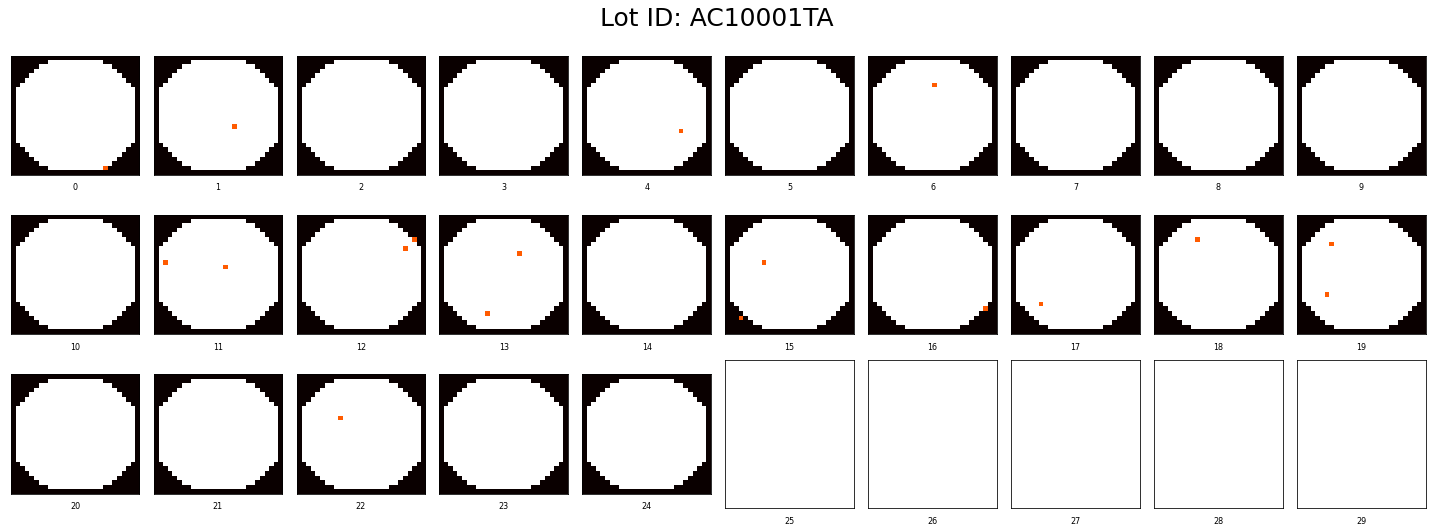

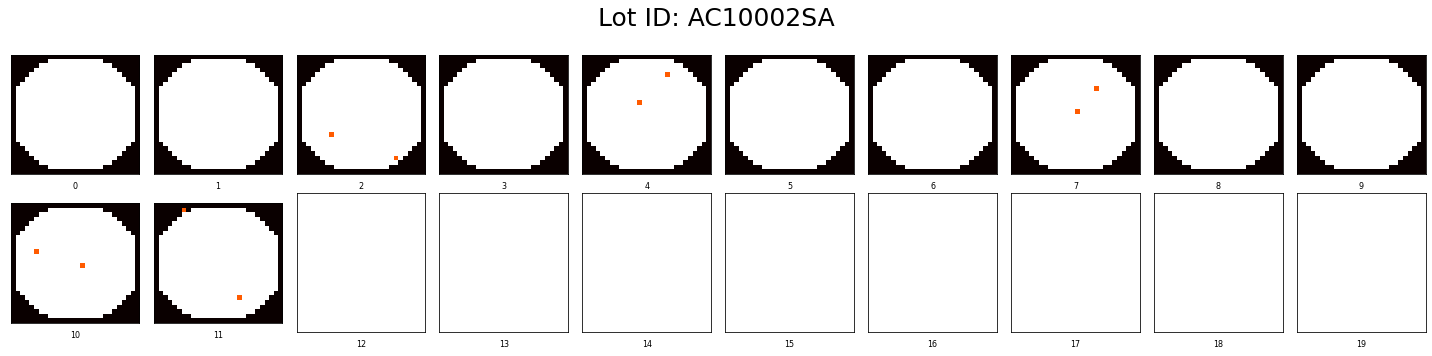

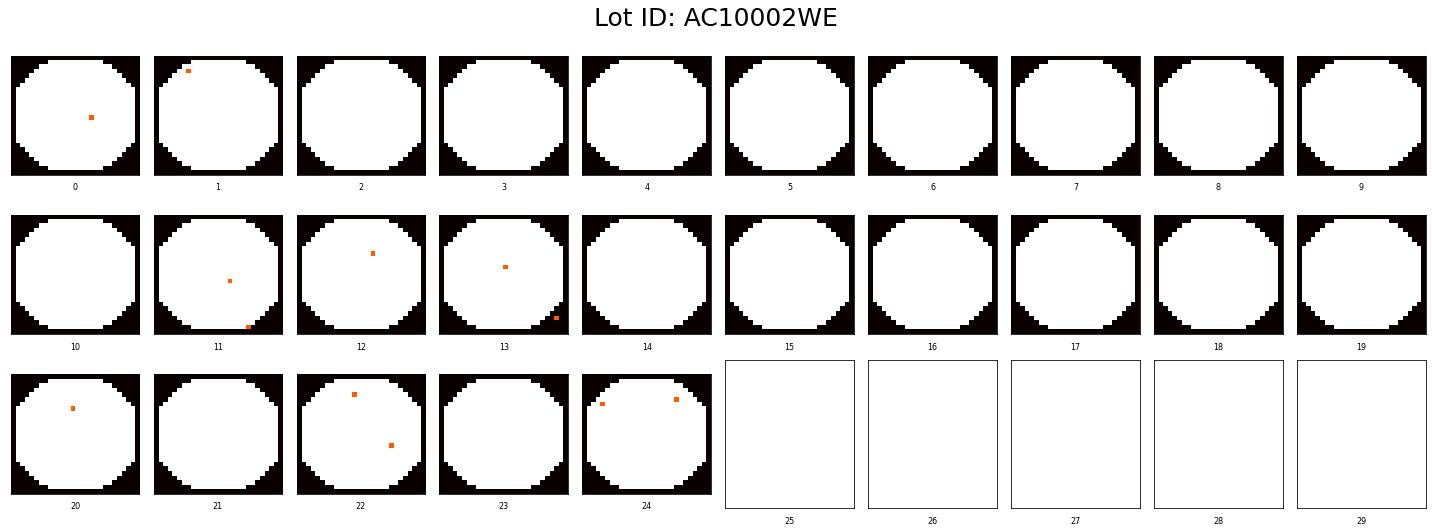

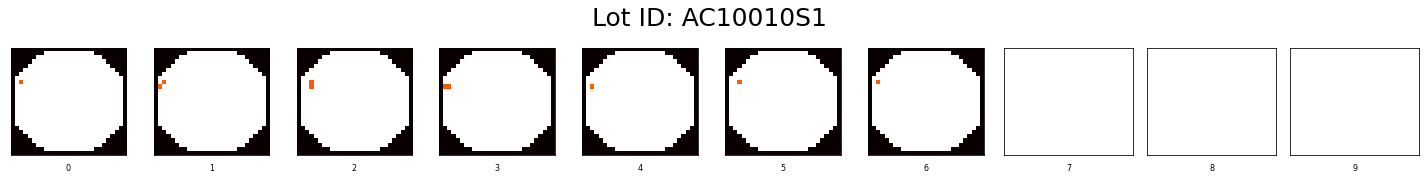

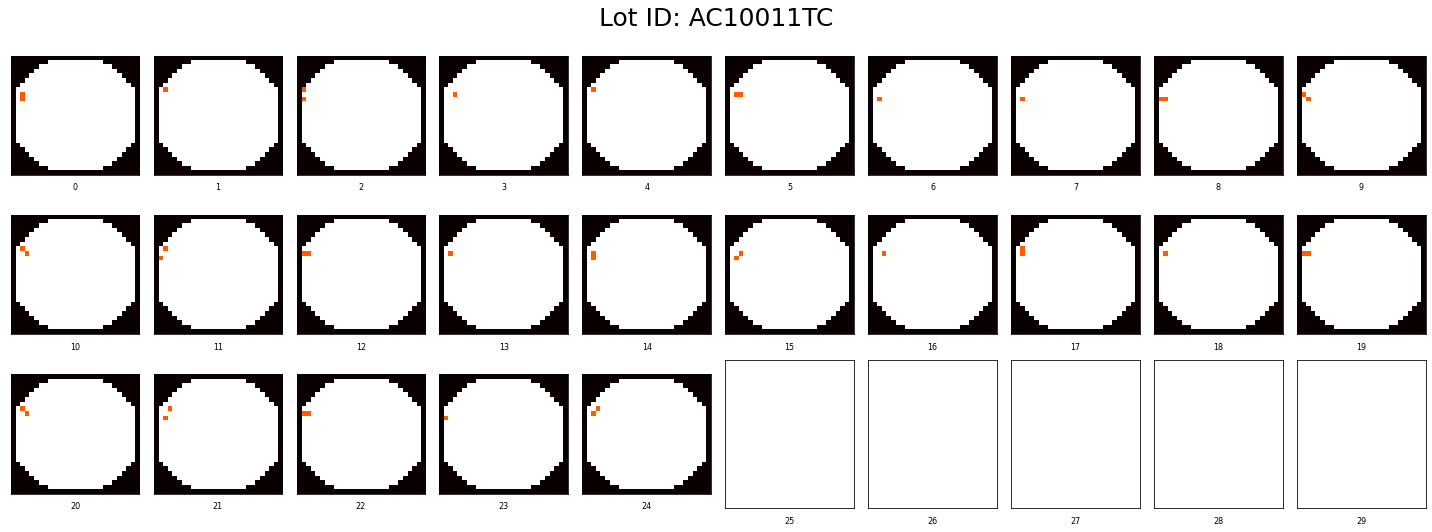

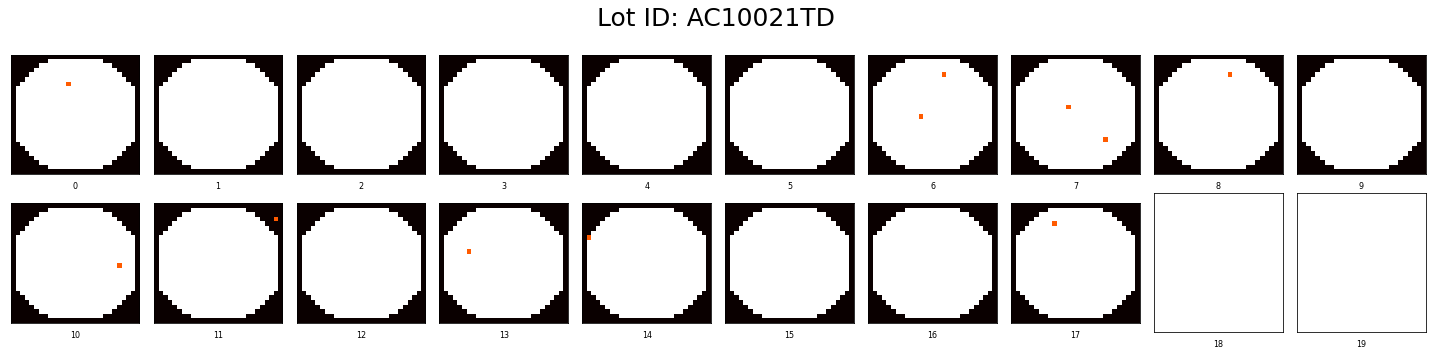

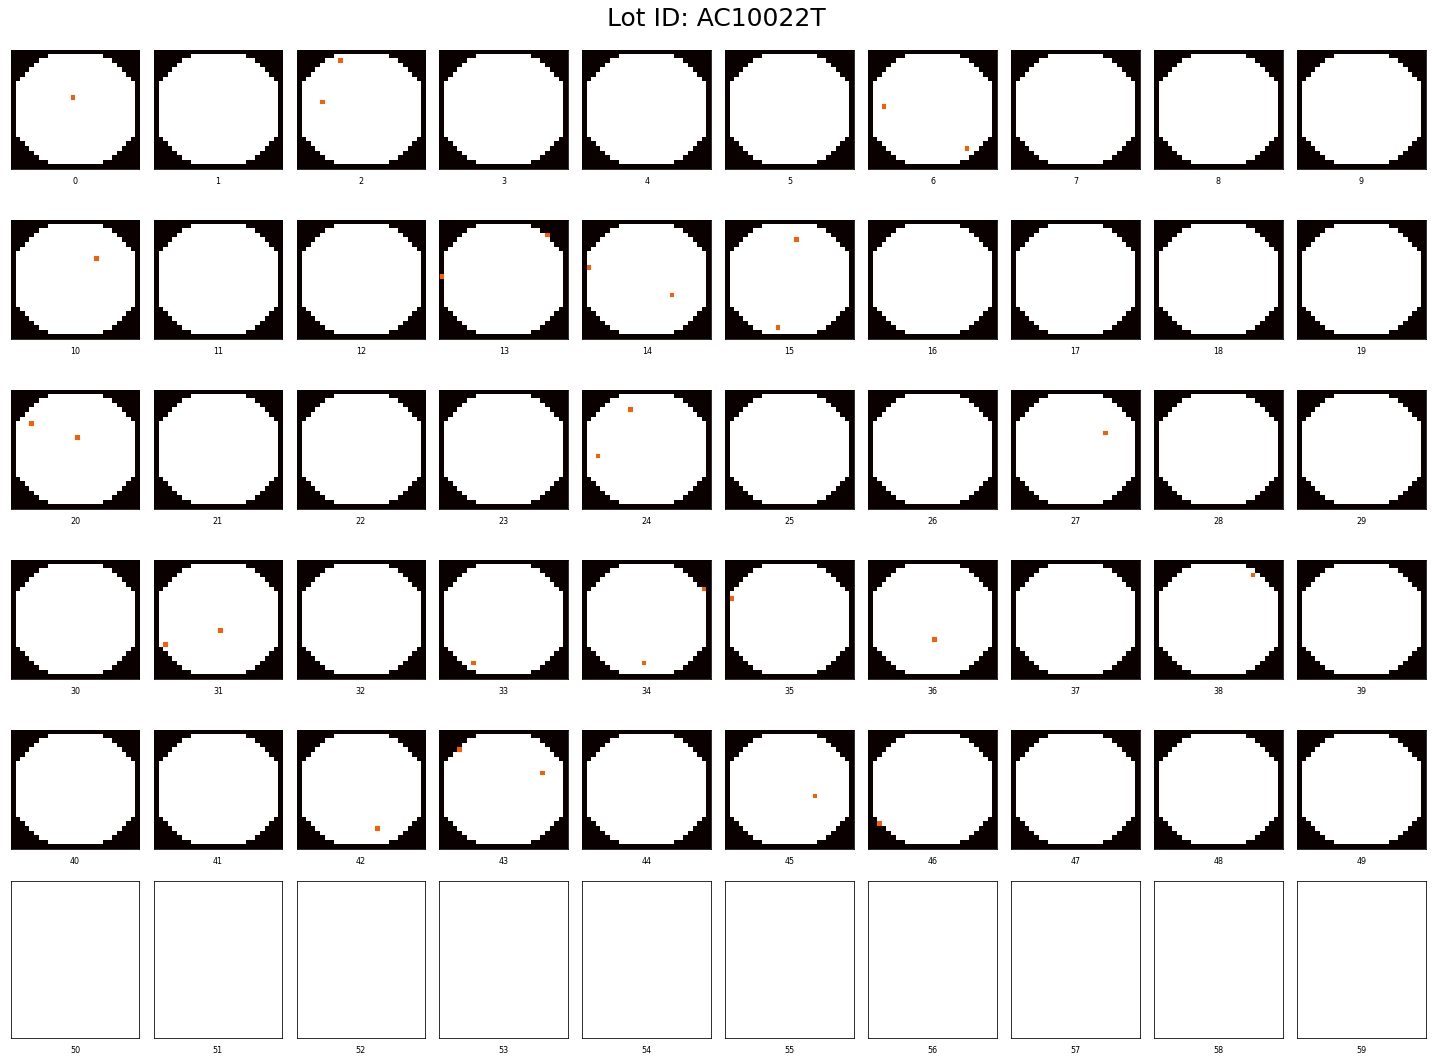

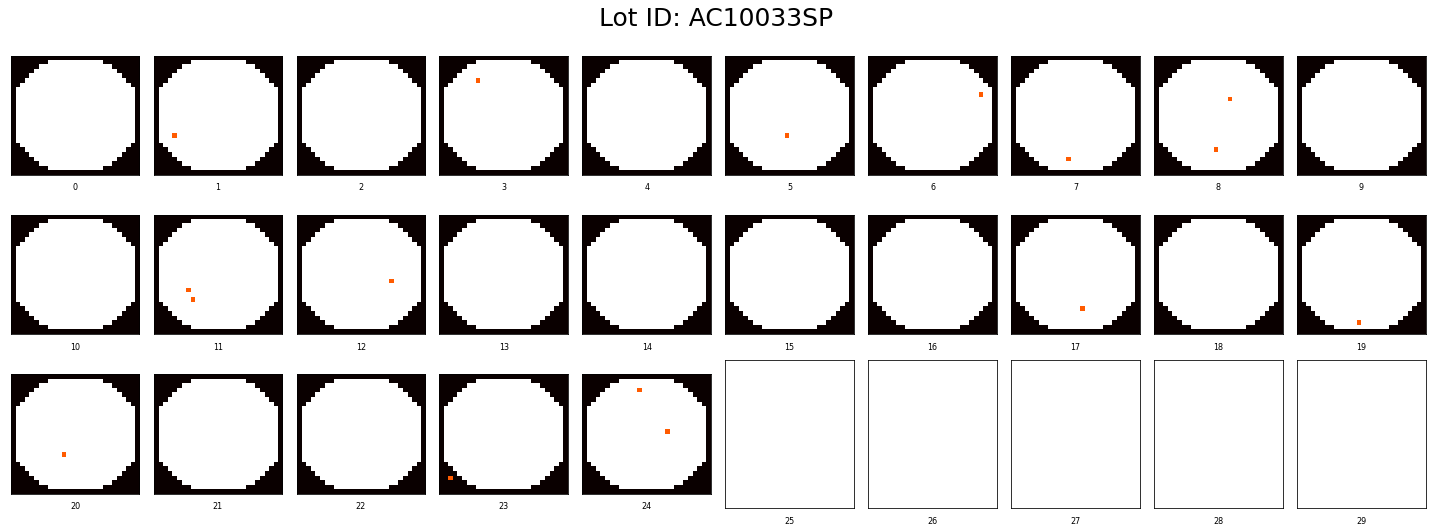

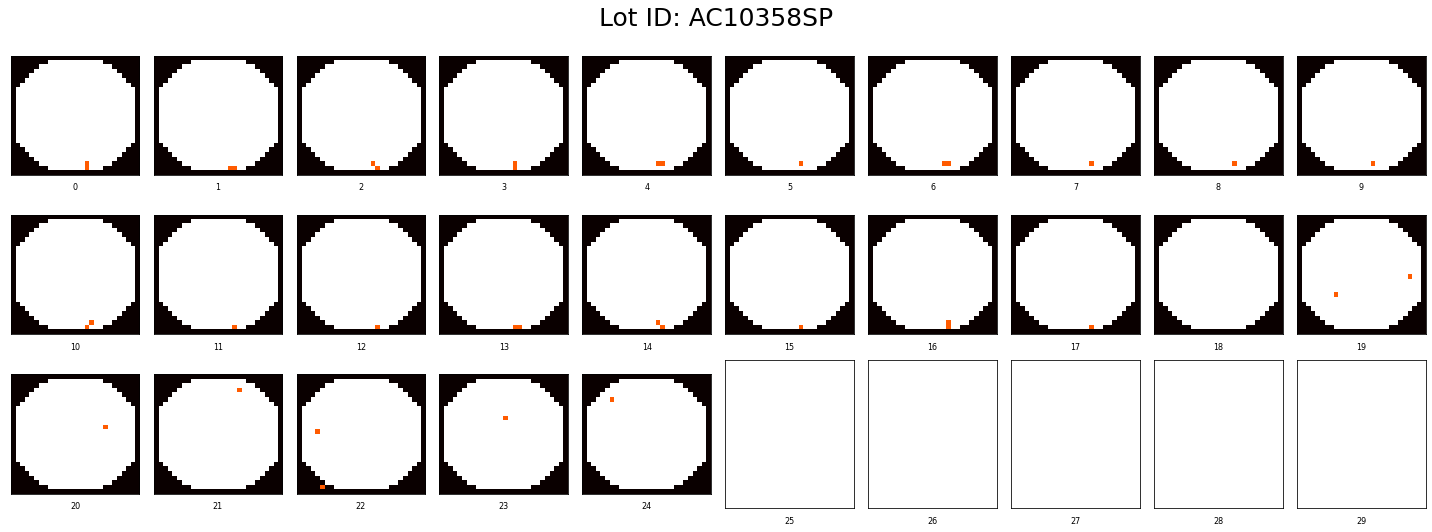

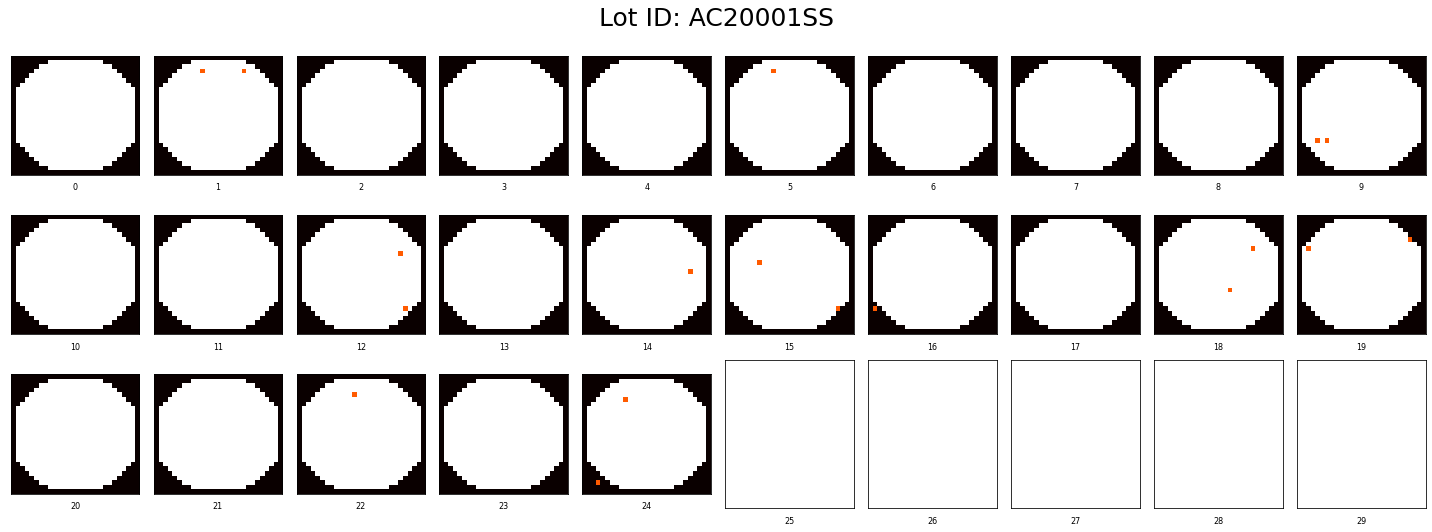

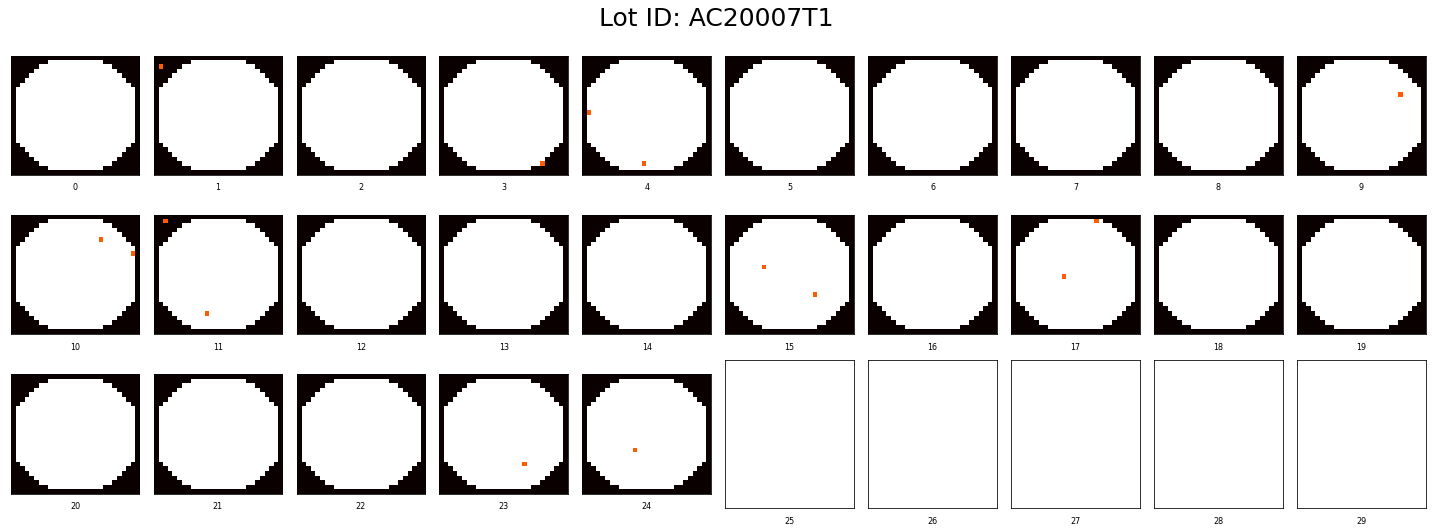

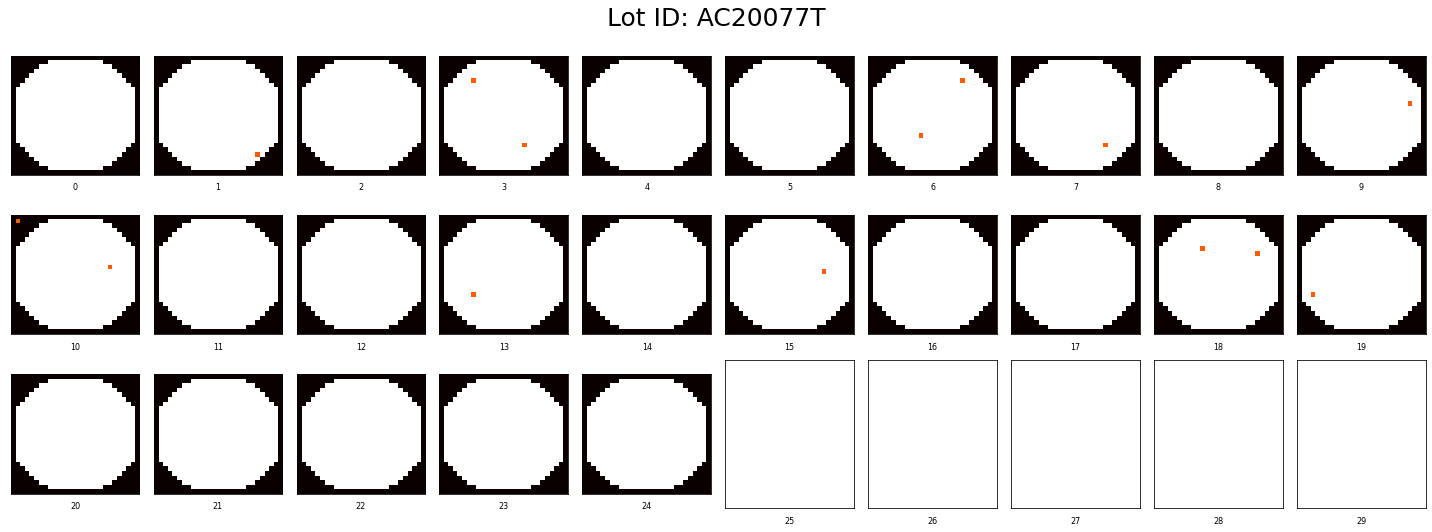

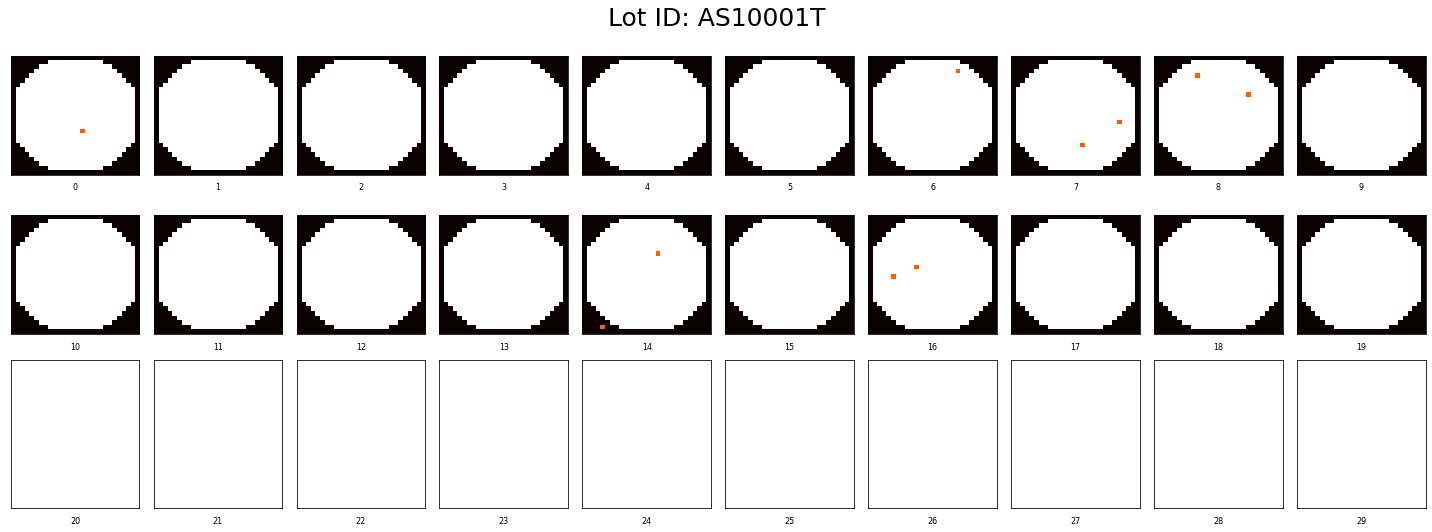

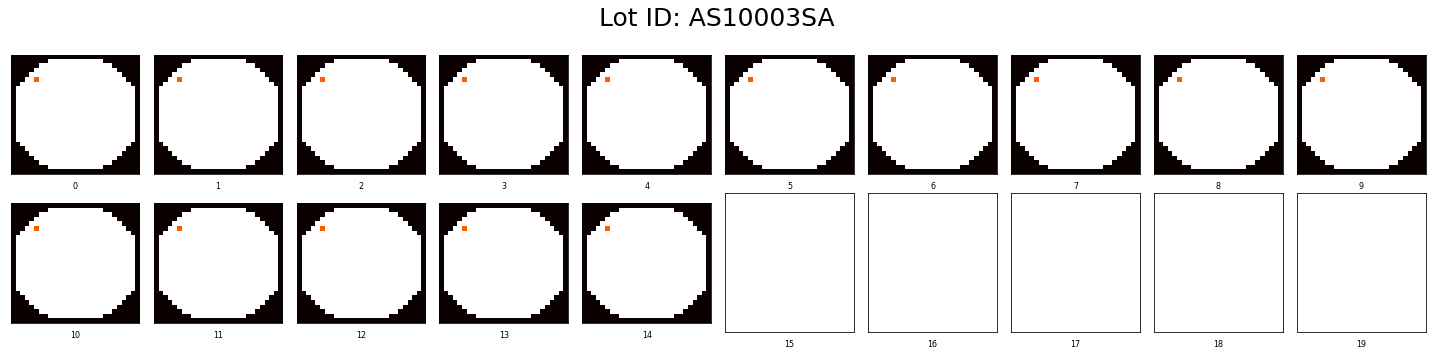

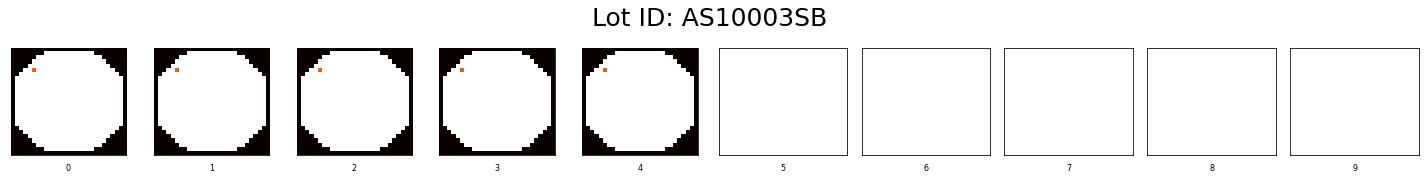

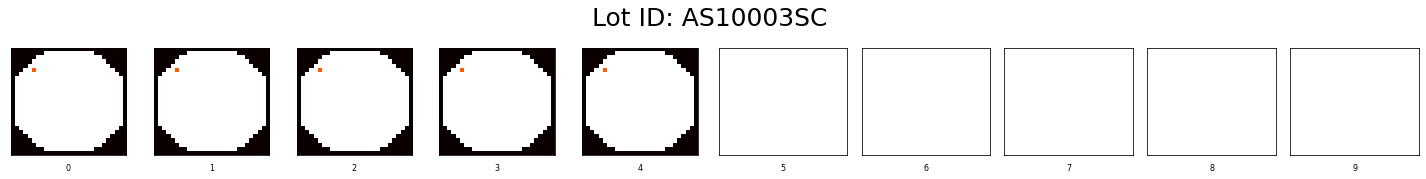

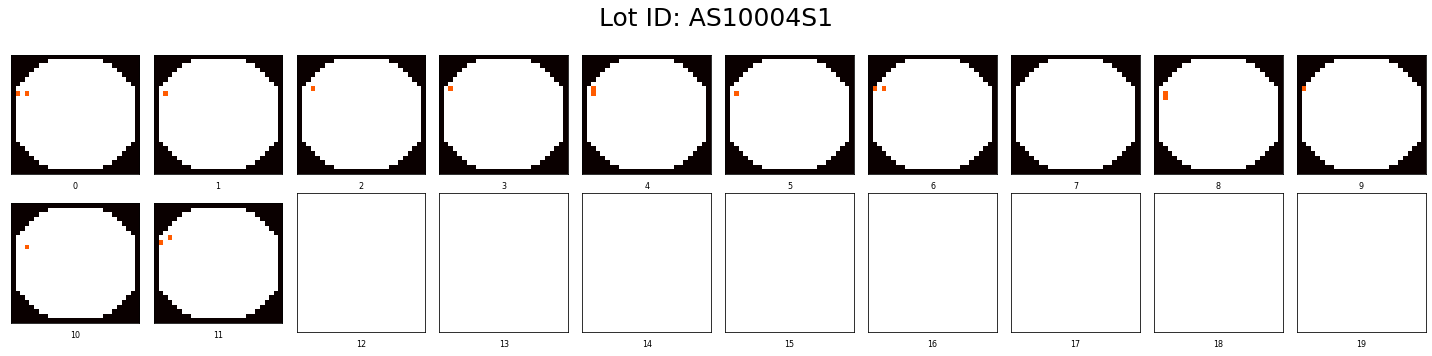

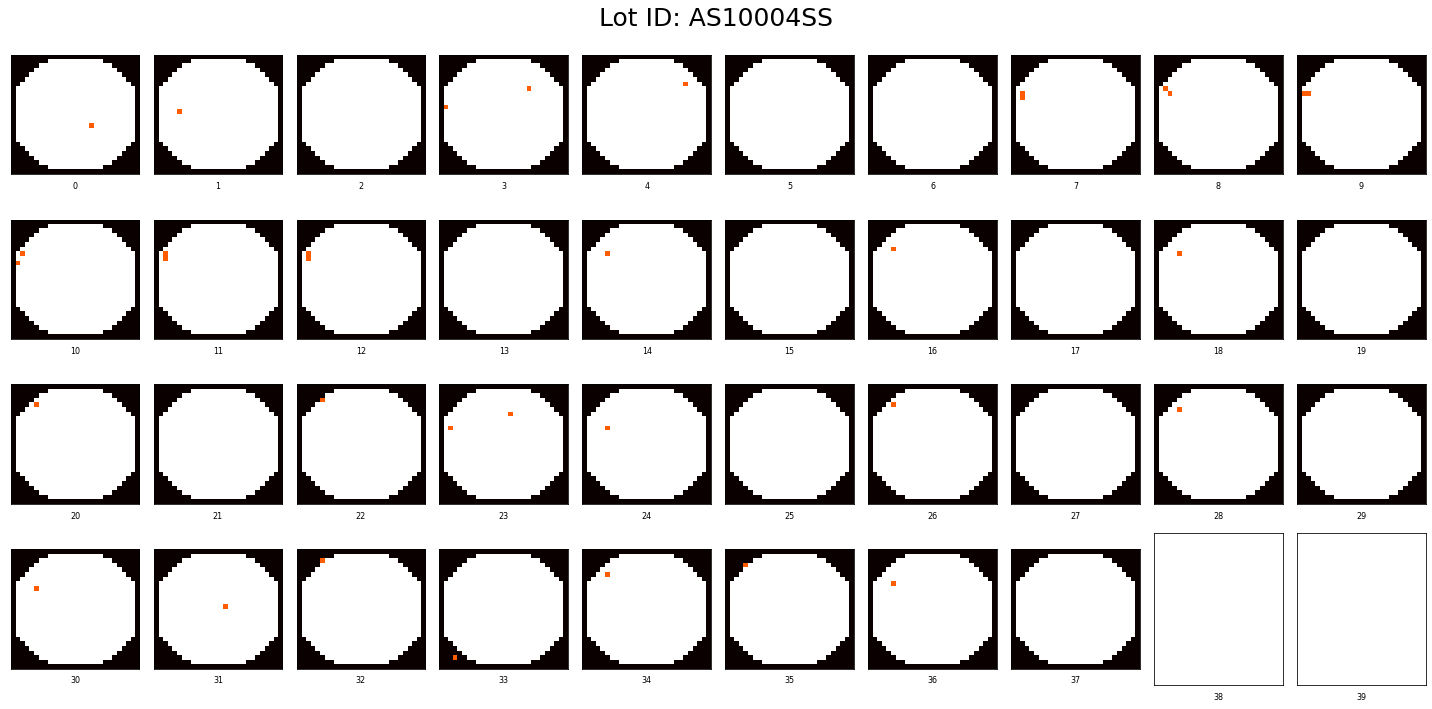

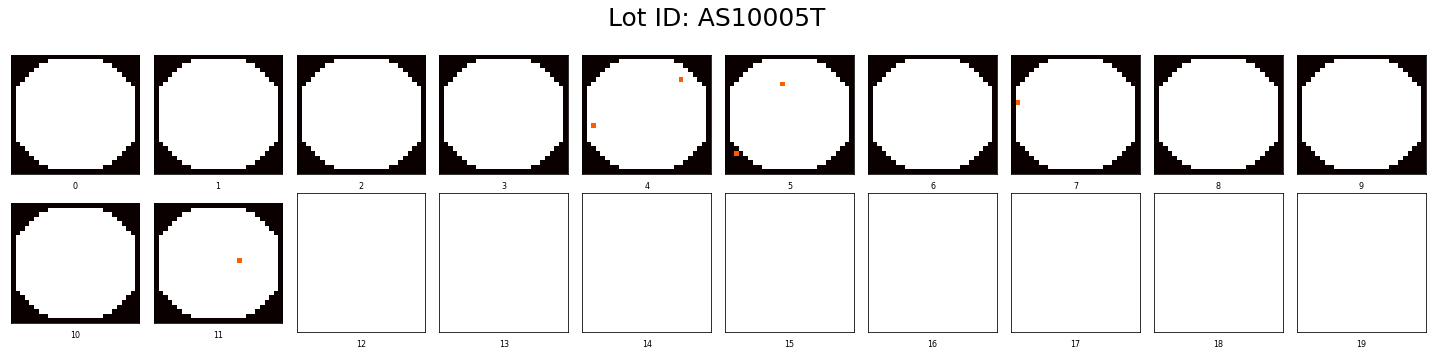

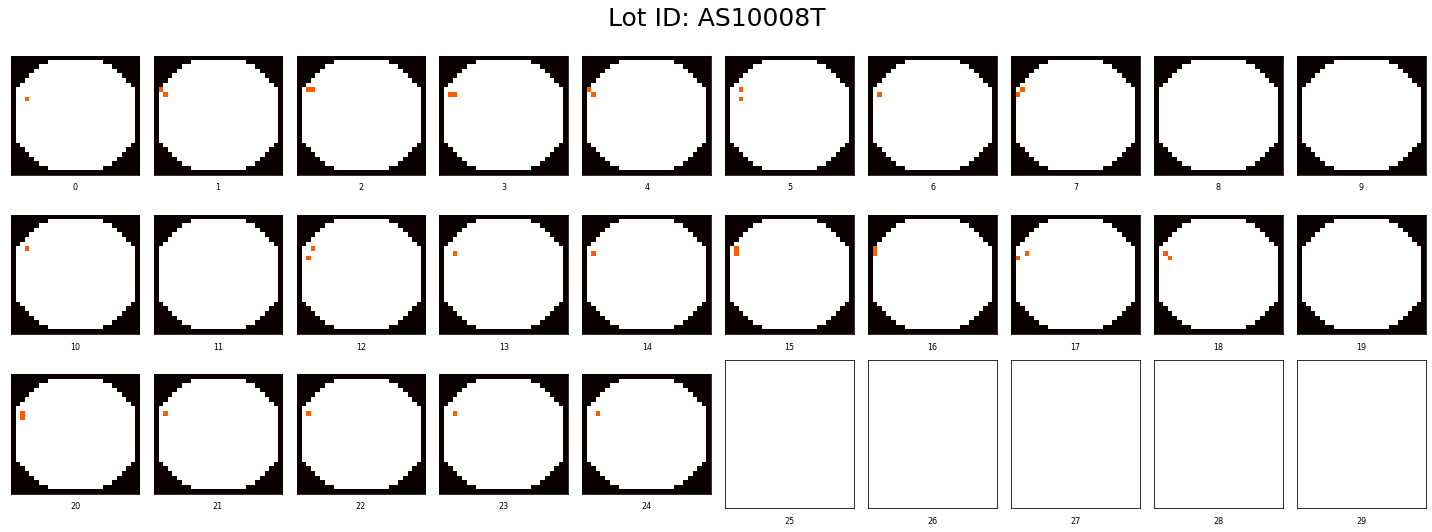

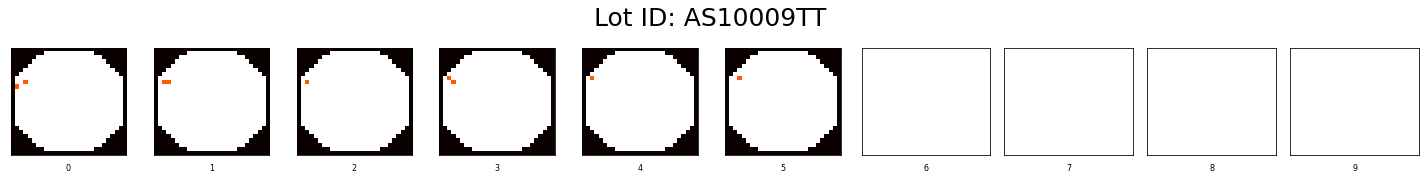

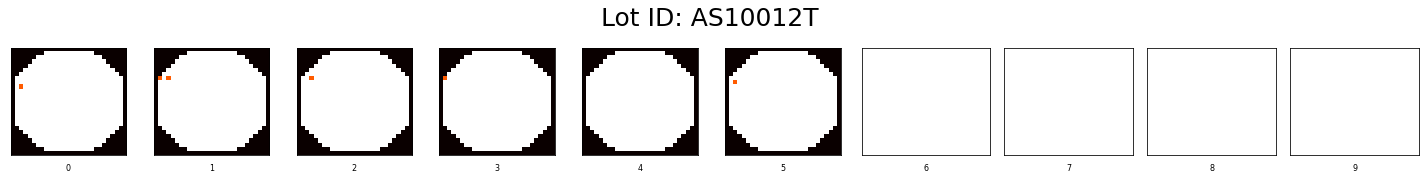

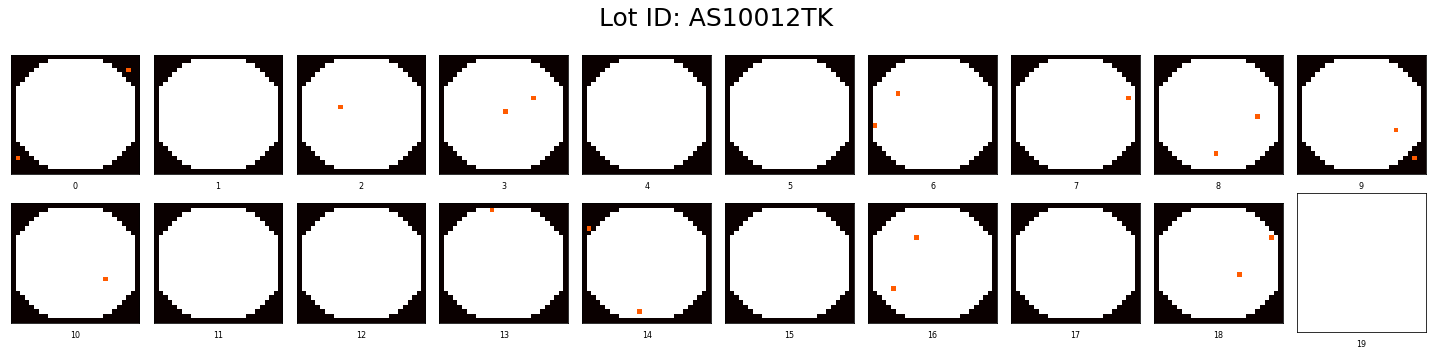

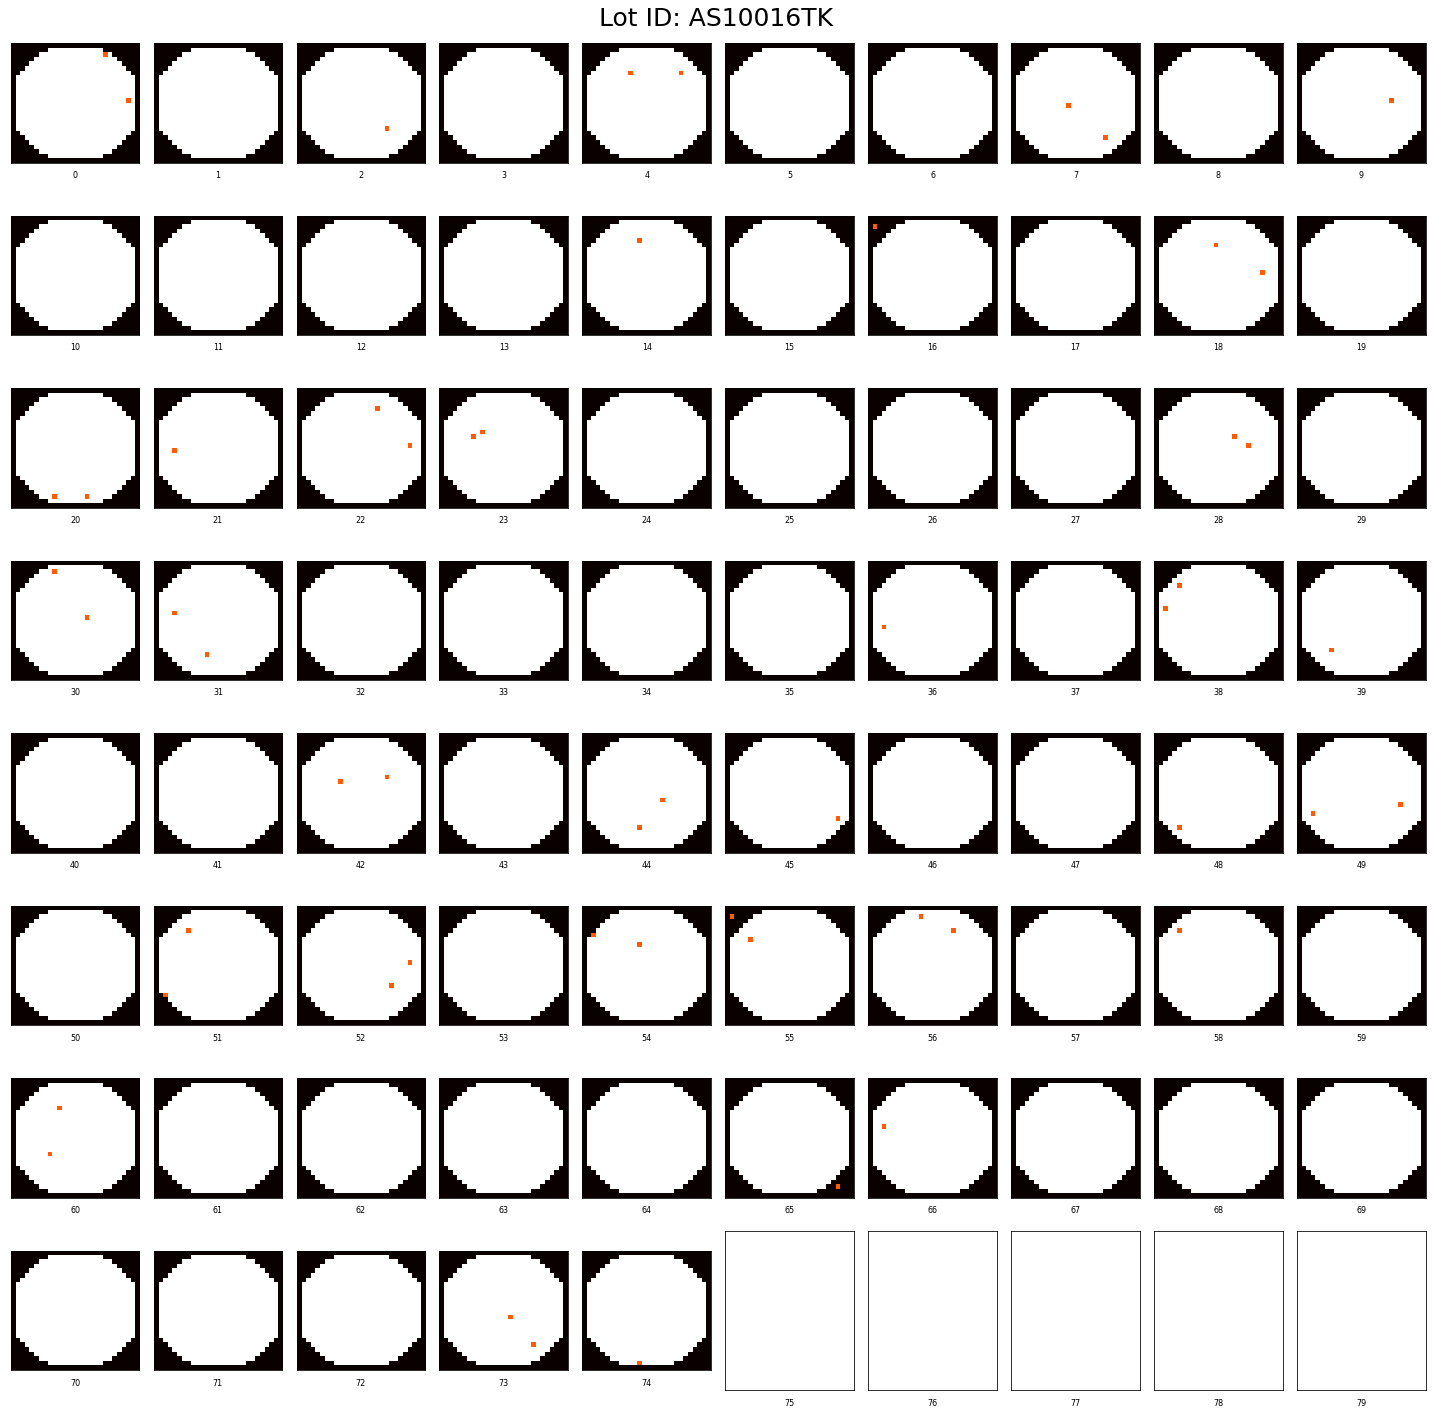

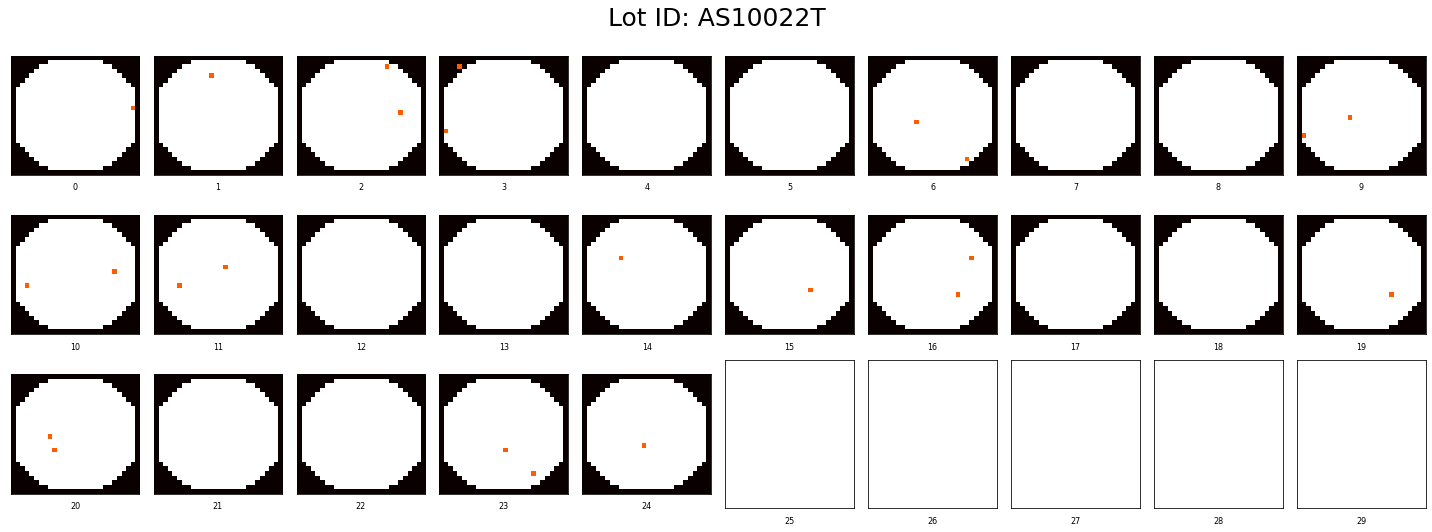

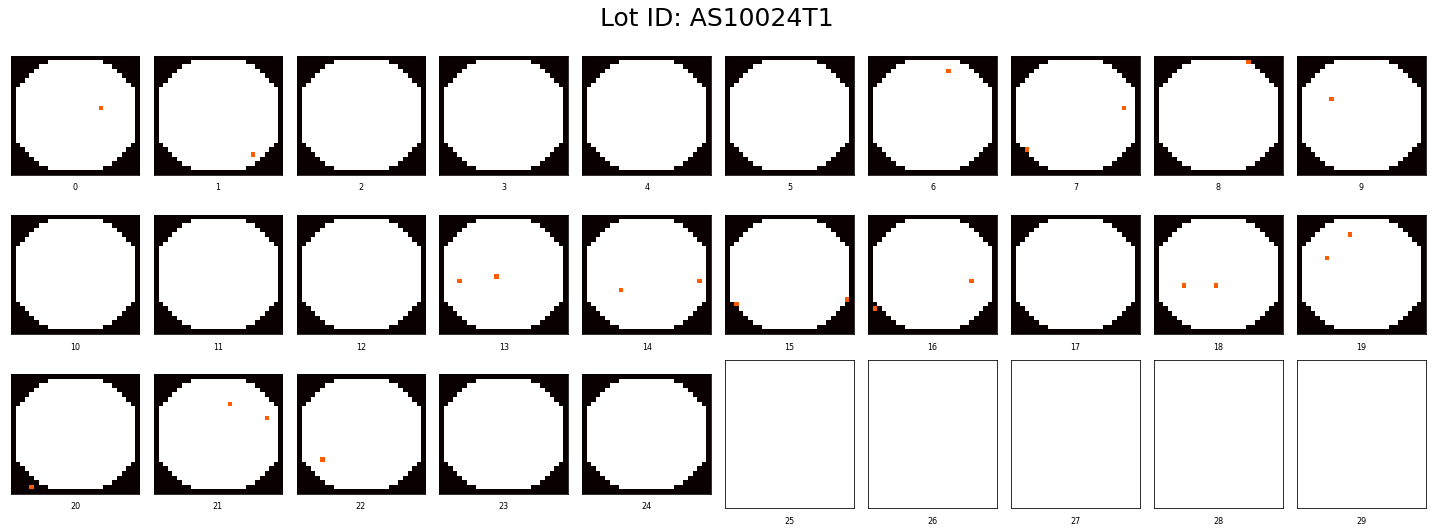

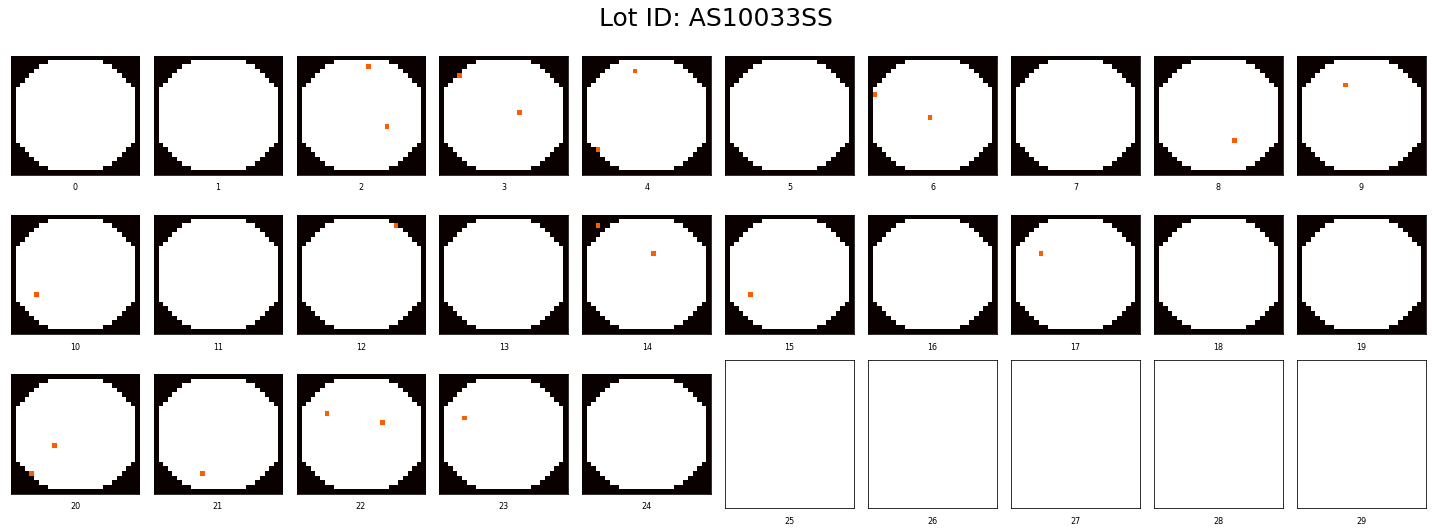

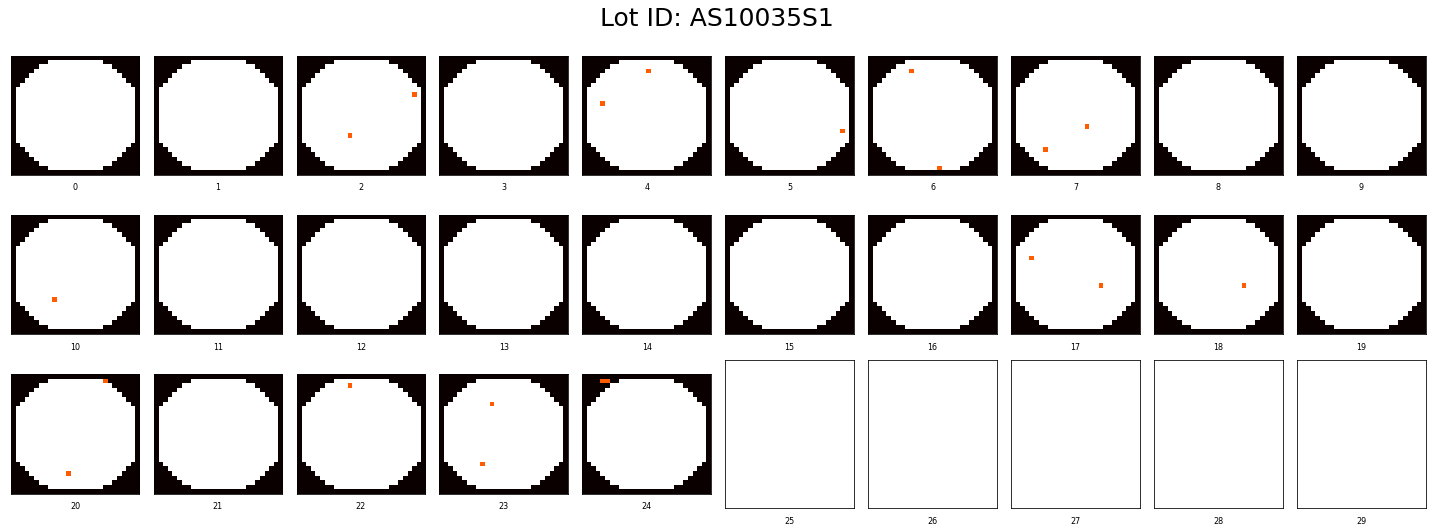

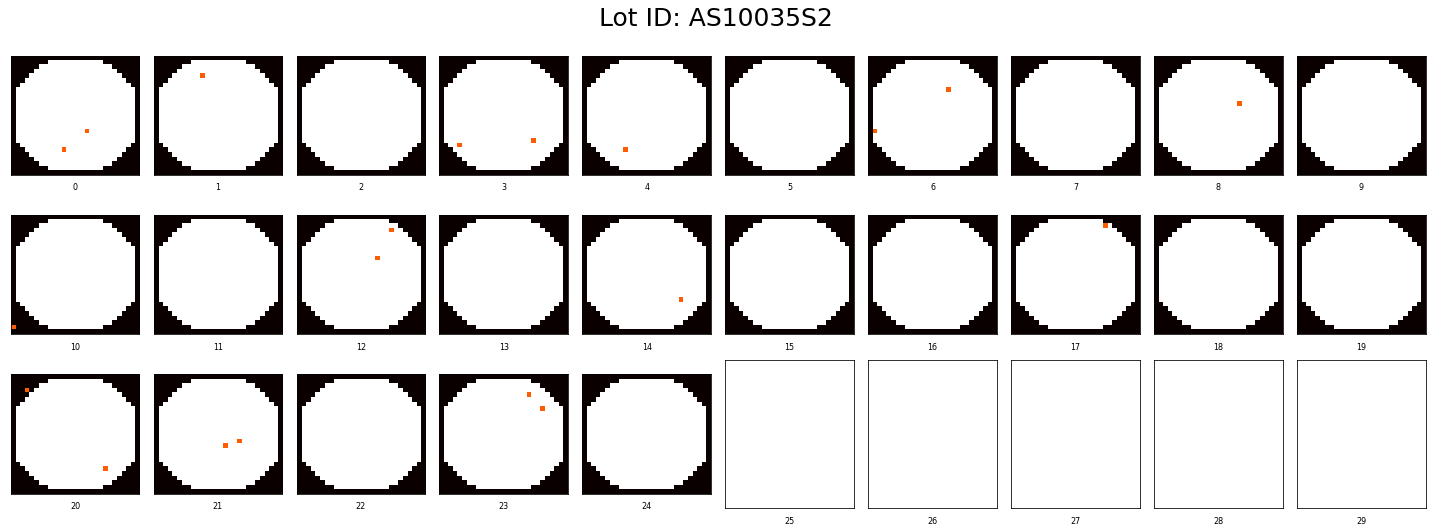

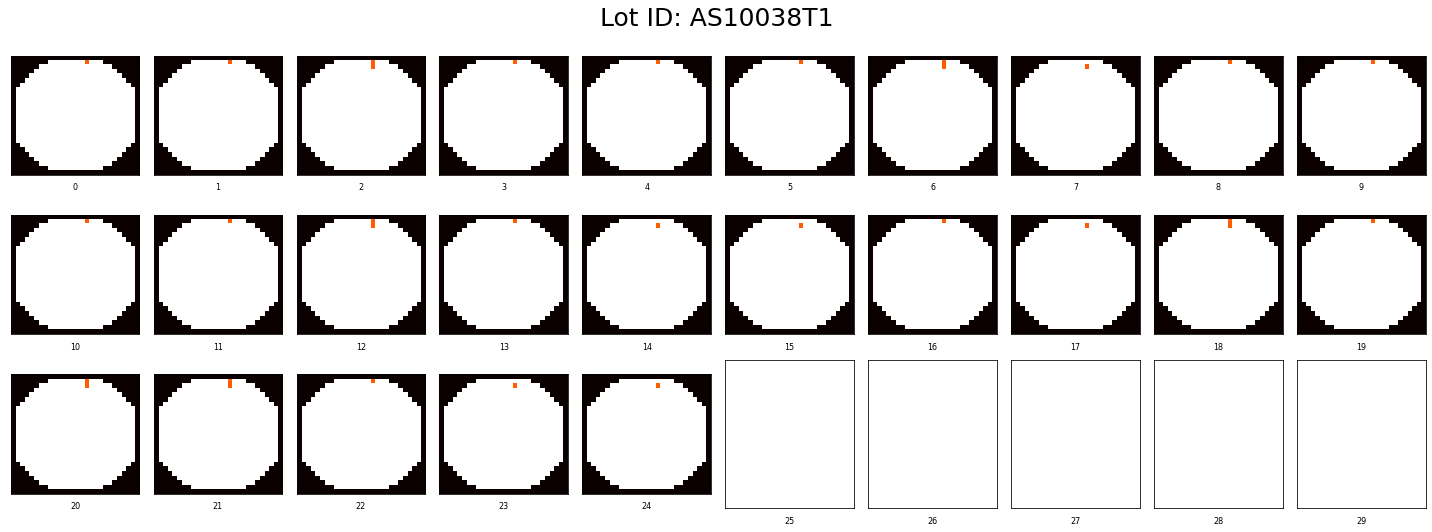

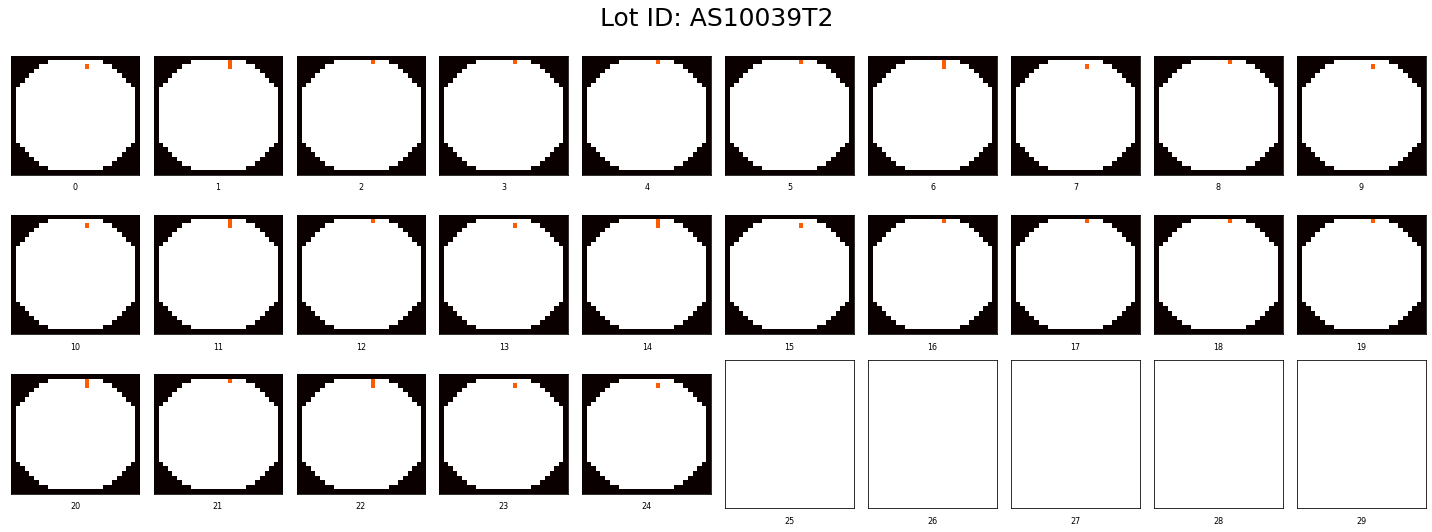

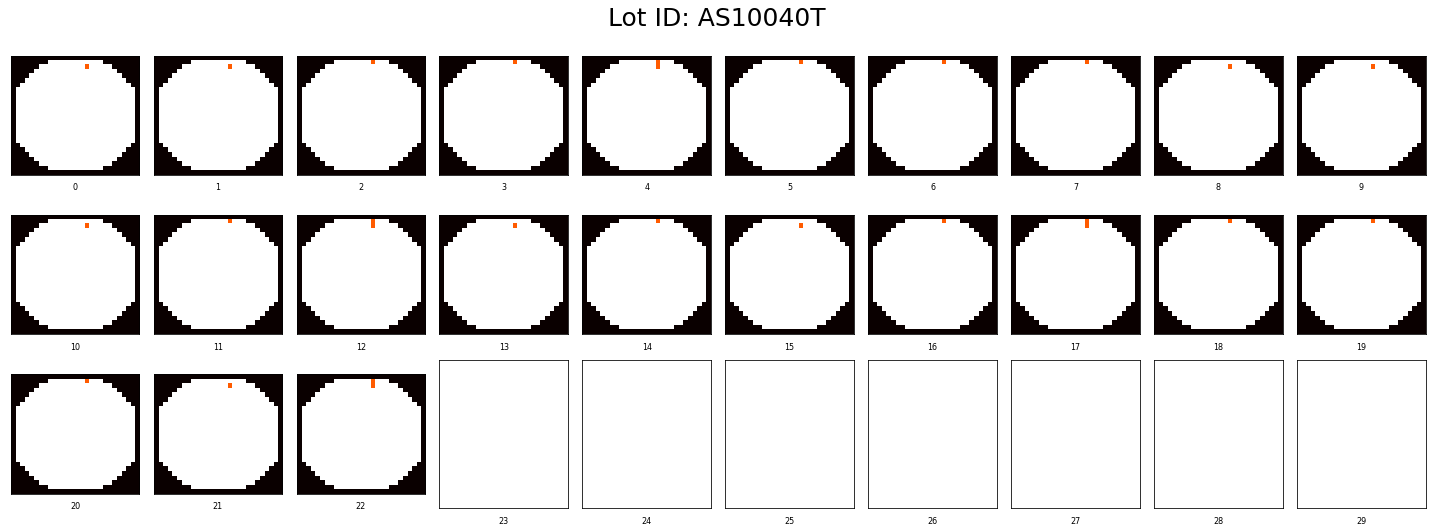

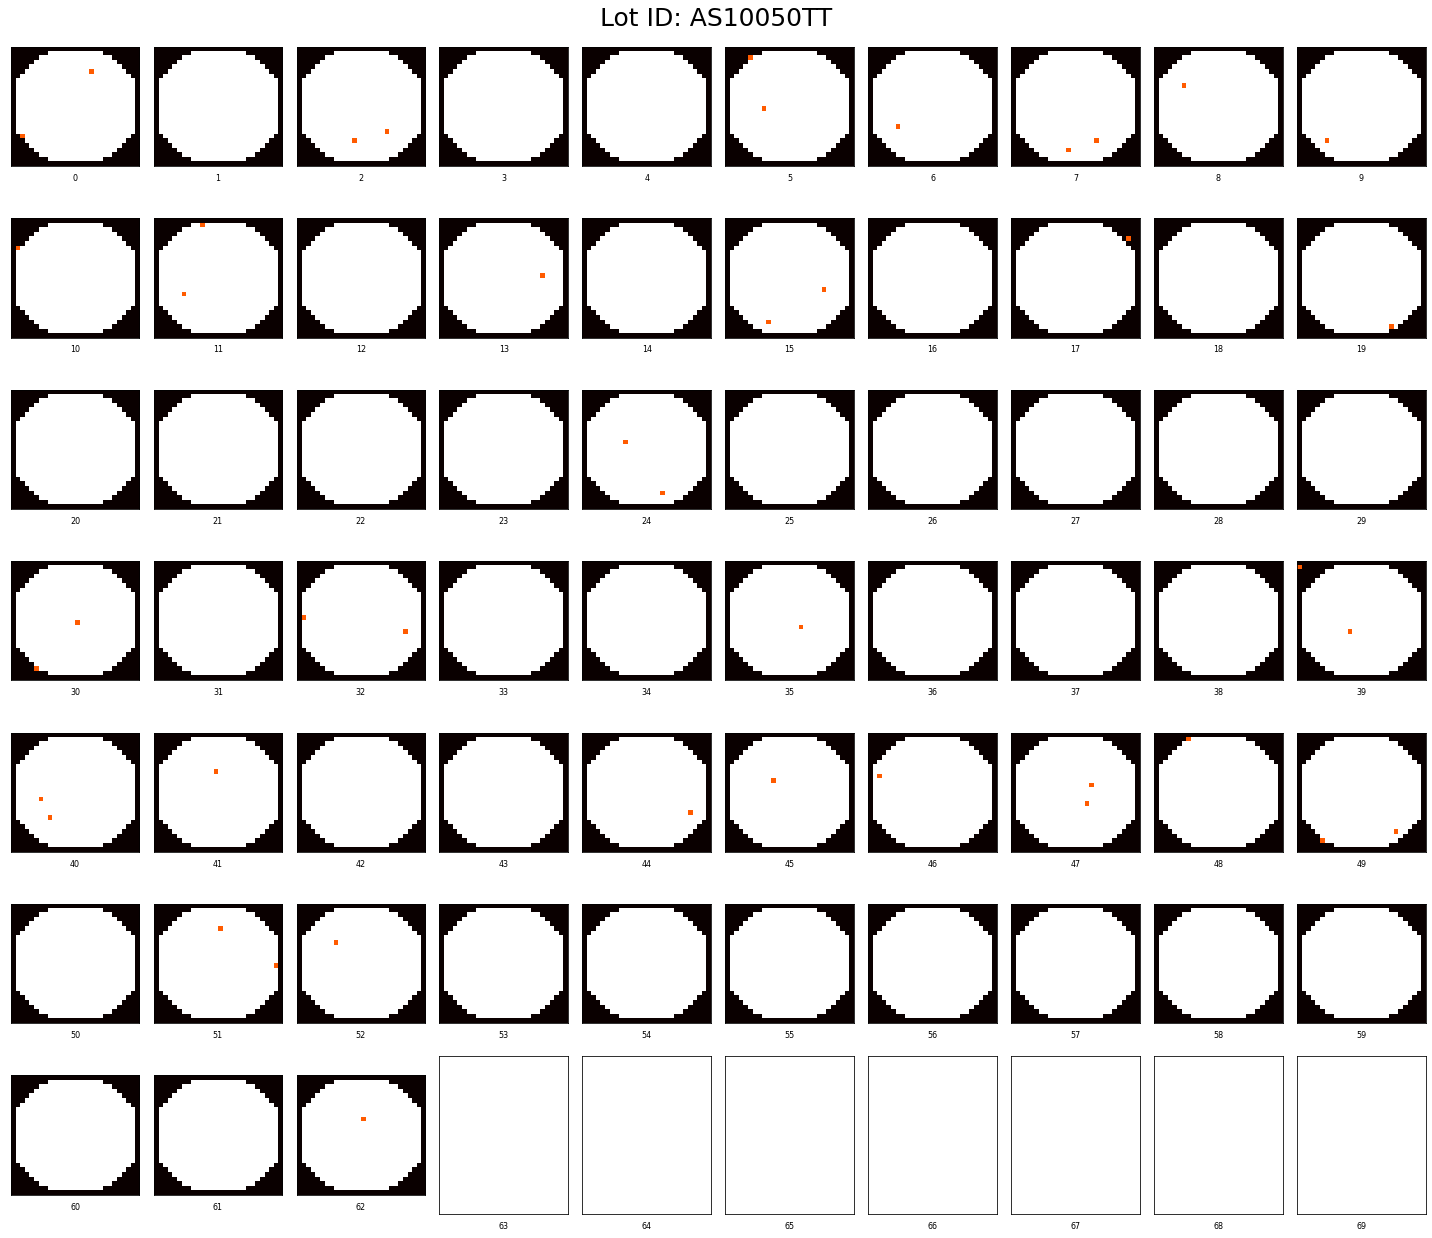

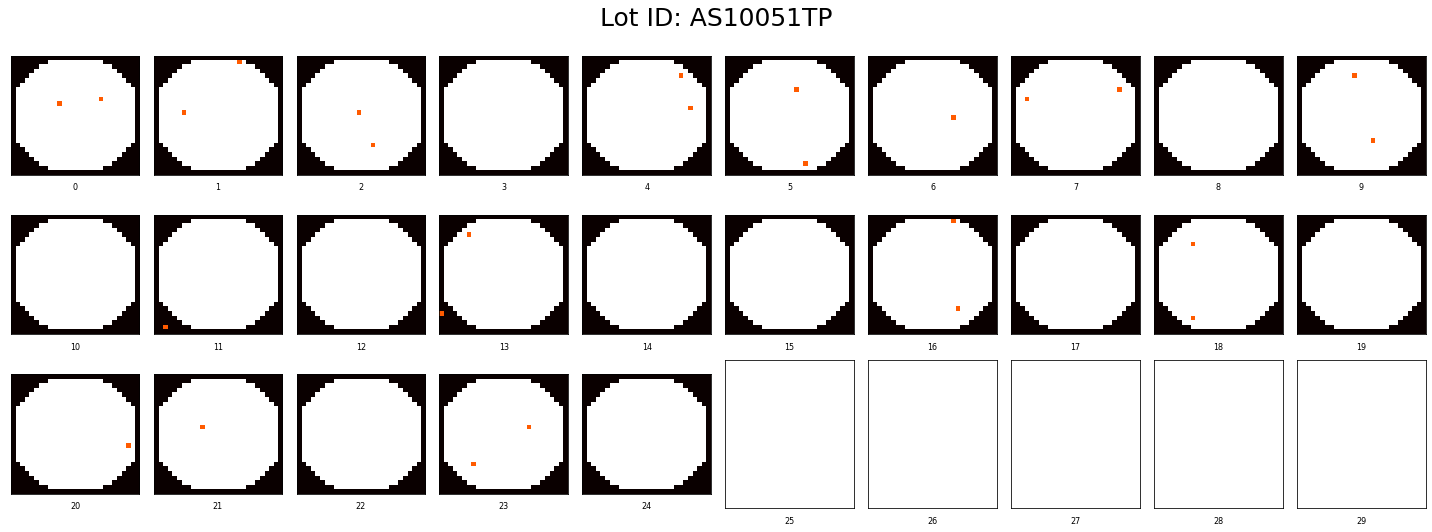

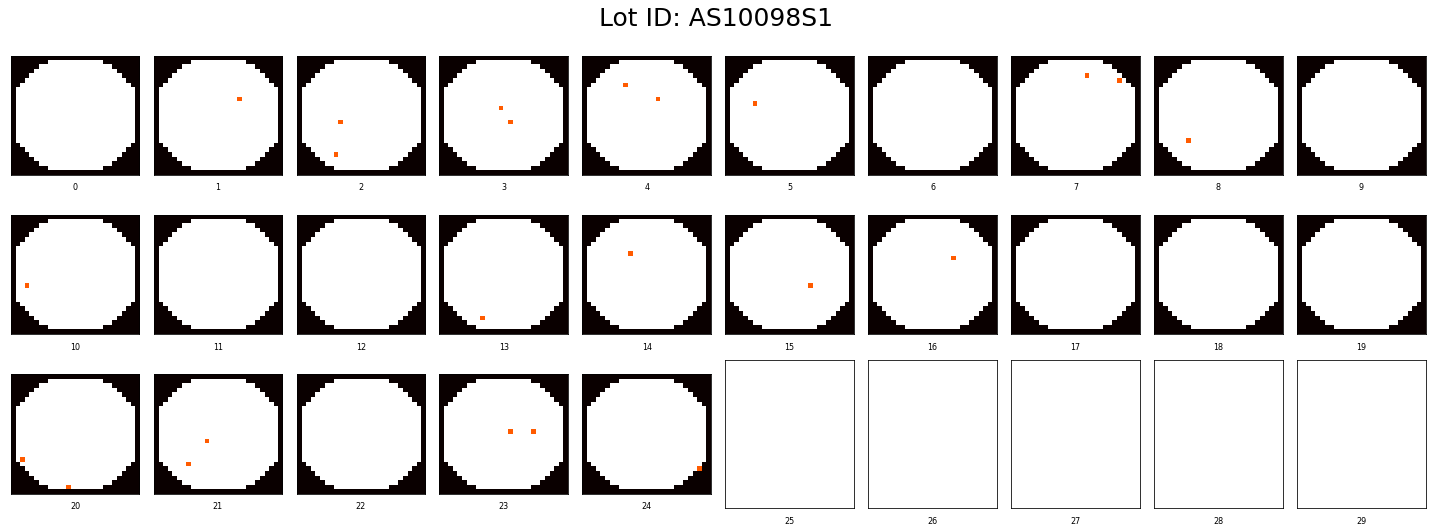

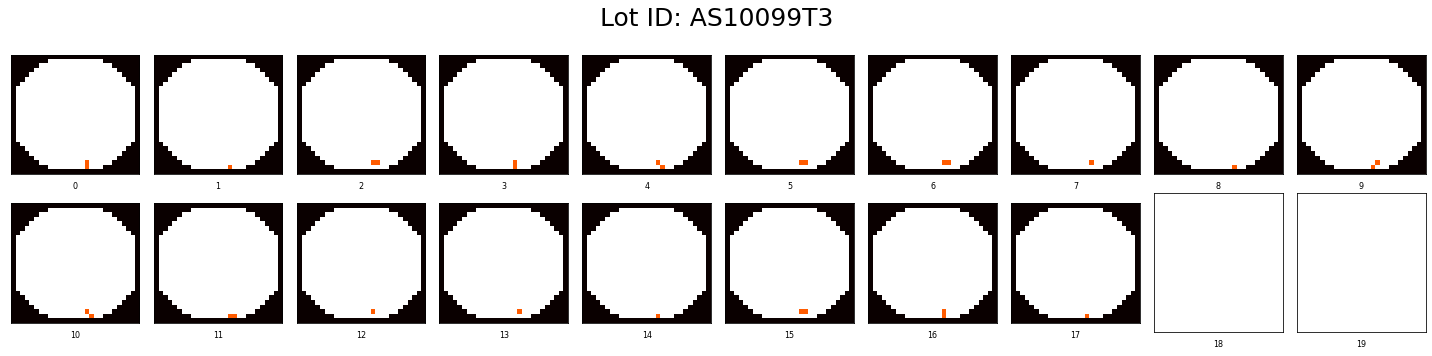

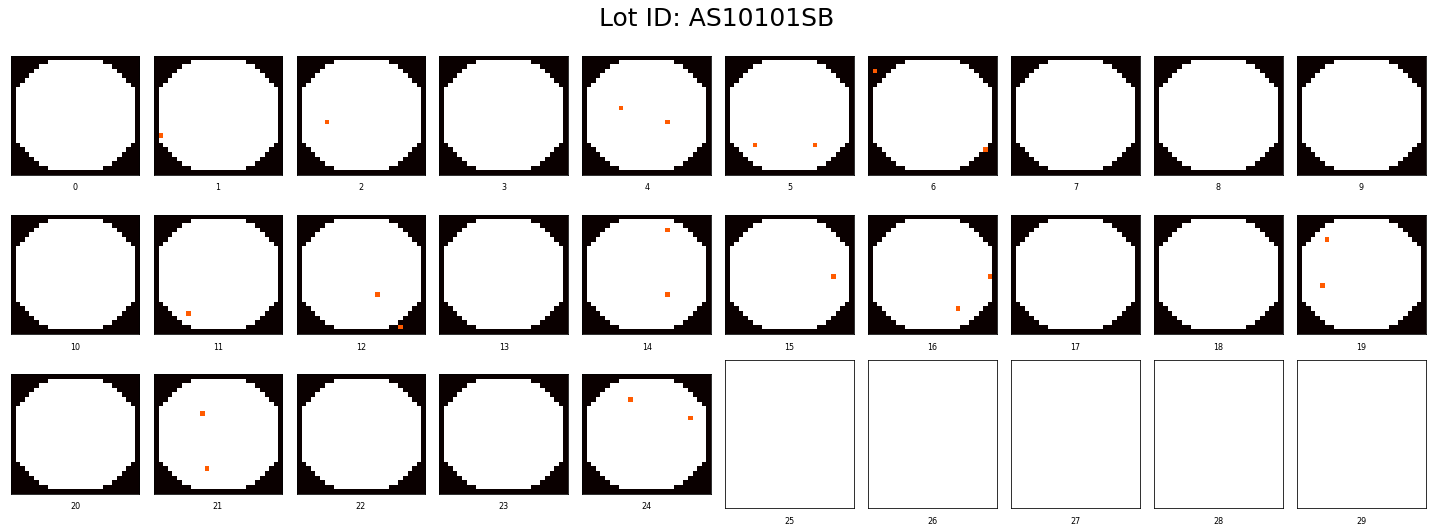

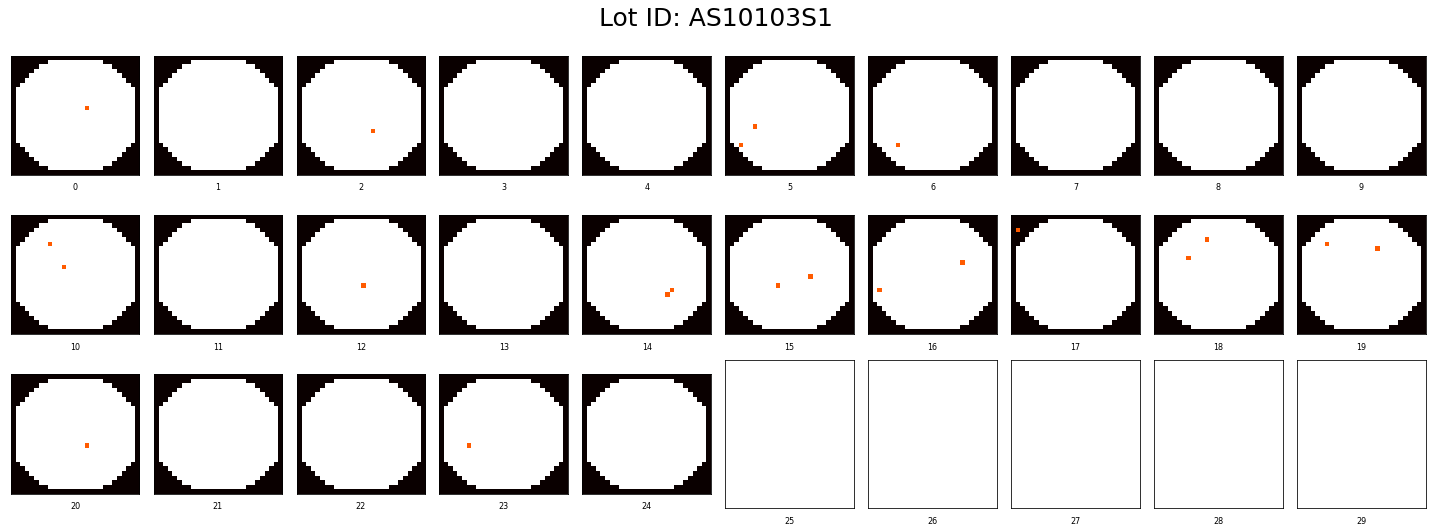

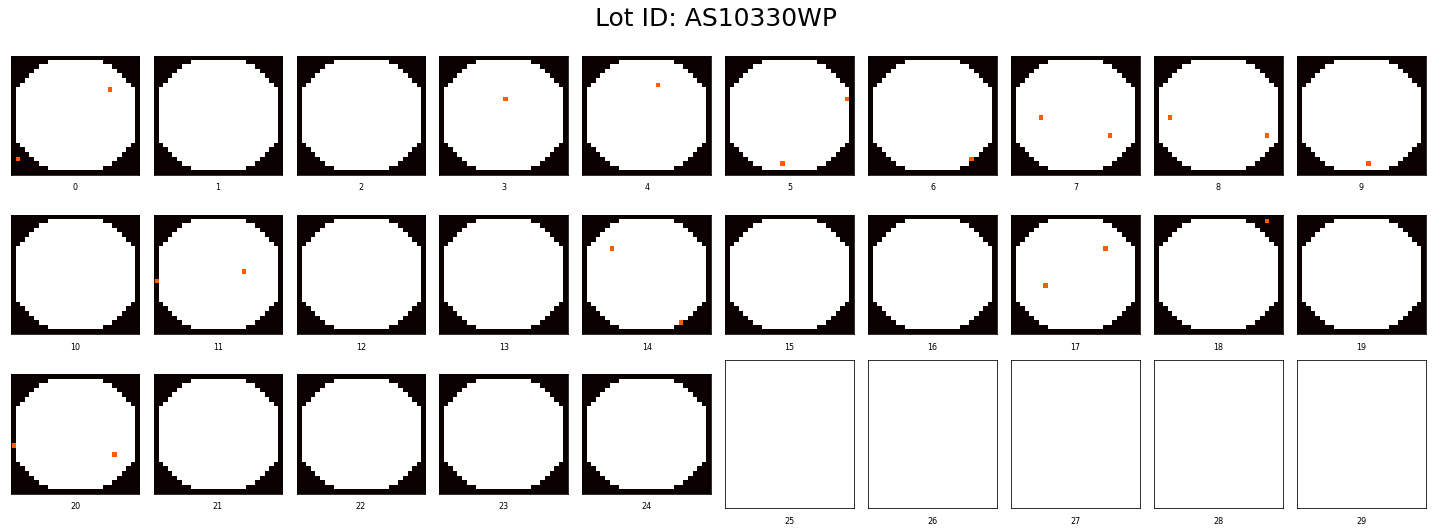

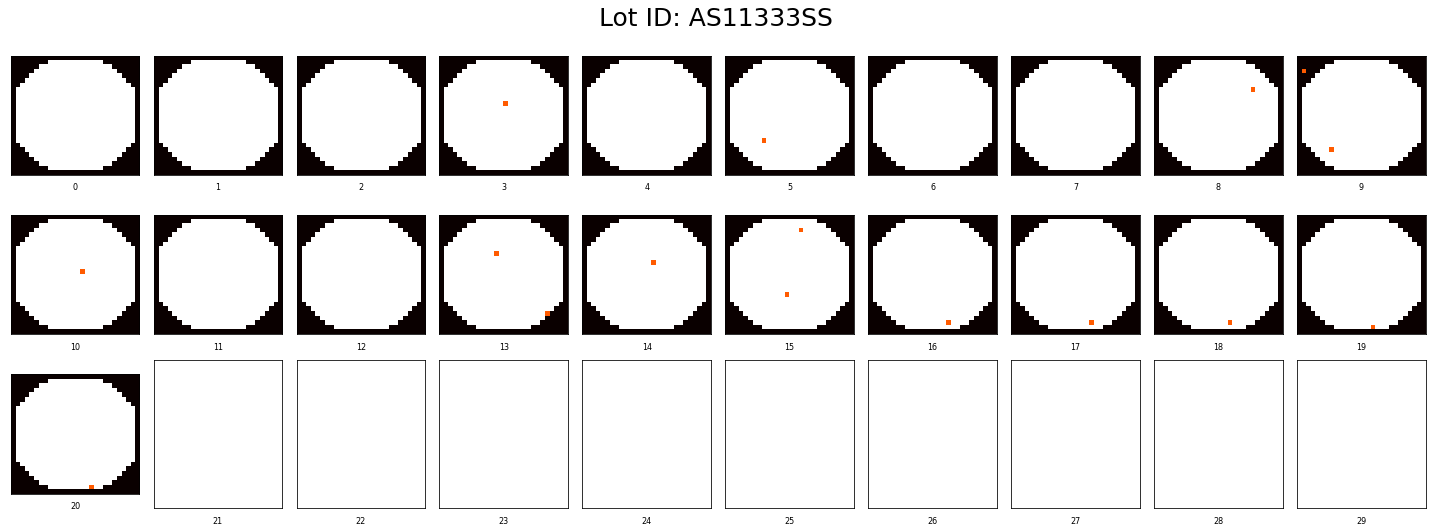

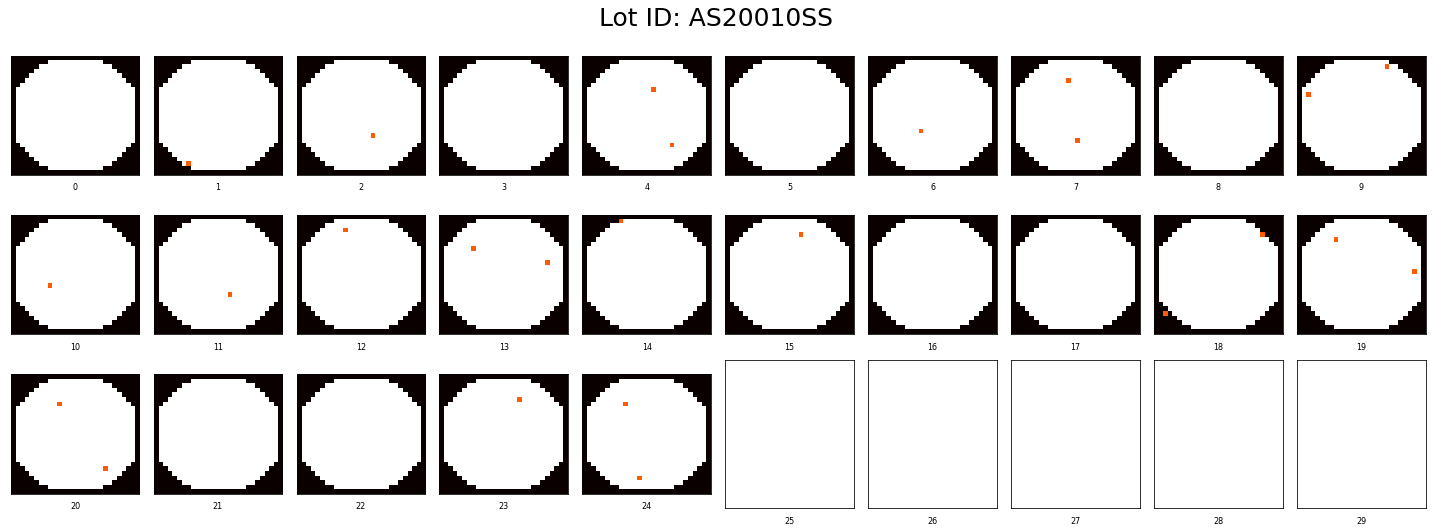

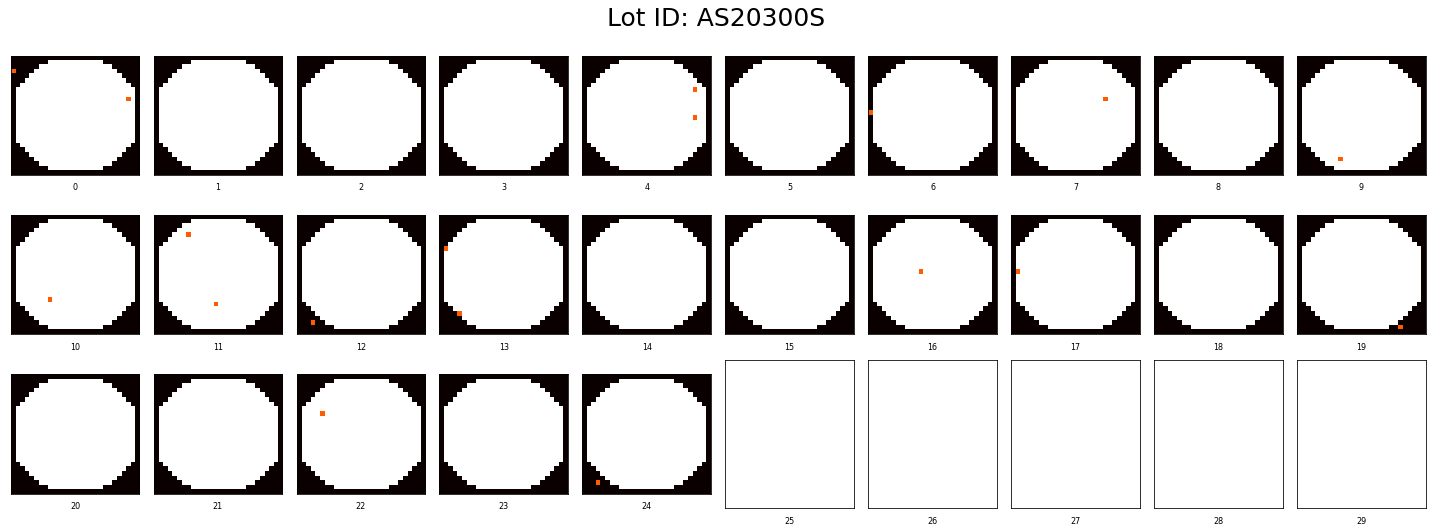

In [190]:
# LotID별 wafer 시각화
def lotid_visualization(lotid):
    nrows = len(defectMaps)//10 + 1
    fig, ax = plt.subplots(nrows=nrows, ncols=10, figsize=(20, nrows*2.5))
    ax = ax.ravel(order='C')
    for i in range(nrows * 10):
        if i < len(defectMaps):
            ax[i].imshow(defectMaps[i], cmap=cm.hot)
        else:
            pass
        ax[i].set_xlabel(f'{i}', fontsize=8)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.suptitle(f"Lot ID: {lotid}", fontsize=25)
    plt.tight_layout()
    plt.show()

for lotid in lot_df.LotID.unique():
    defectMaps = []
    temp = lot_df[lot_df.LotID == lotid] 
    for i in range(len(temp)):
        base = base_wafer.copy()
        for j in range(len(temp.iloc[i,:].MAP)):
            defect_x = temp.iloc[i,:].MAP[j].split(' ')[0]
            defect_y = temp.iloc[i,:].MAP[j].split(' ')[1]
            if not defect_x == '0':
                base[int(defect_x), int(defect_y)] = 0.5
        defectMaps.append(base)
    lotid_visualization(lotid)
    print("="*120)
    print("="*120)

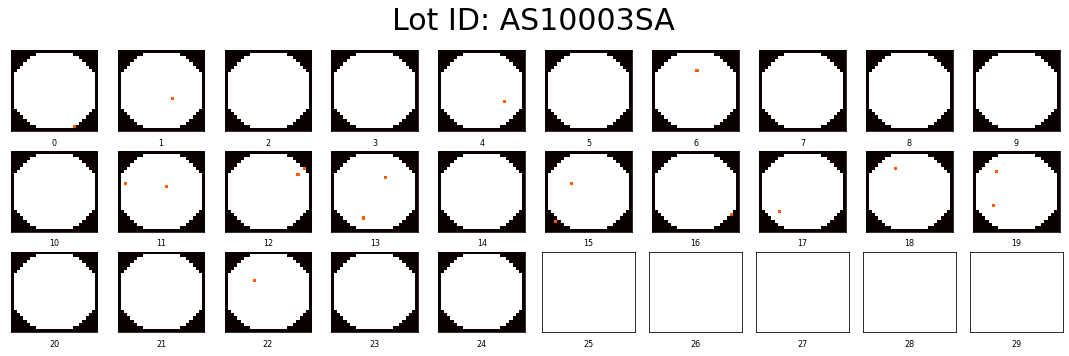

In [181]:
# AS10003SA: class 1
lotid_visualization("AS10003SA")

In [ ]:
# LotID 기준 defect 시각화
defectMaps=[]
for fp in file_path:
    base = base_wafer.copy()
    filename = os.path.split(fp)[1]
    defect_x = defect_df[defect_df.FILE == filename.split('.')[0]][["XINDEX"]].astype('int').values
    defect_y = defect_df[defect_df.FILE == filename.split('.')[0]][["YINDEX"]].astype('int').values
    
    if (defect_x == 0).all():
        pass
    else:
        for i in range(defect_x.size):
            base[defect_x[i][0], defect_y[i][0]] = 0.5
    defectMaps.append(base)
    
# 임의의 defect map 시각화
visualization_wafer(defectMaps[55],8, "Defects Map")

In [ ]:
# LotID 기준 wafer defect 변화 확인
# fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(20,10))
# ax = ax.ravel(order='C')
# for i in range(50):
#     ax[i].imshow(defectMaps[i], cmap=cm.hot)
#     ax[i].set_xlabel(f'{i}', fontsize=8)
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])
# plt.tight_layout()
# plt.show()

<h3>WaferID 기준</h3>

- 동일 WaferID로 그룹화

In [129]:
temp_df.sort_values(["WaferID", "Timestamp"]).tail(30)

,FileName,LotID,WaferID,Timestamp,MachineID,StepID,DeviceID
197,AS20010SS_AS20010-21_01-02-23_198,AS20010SS,AS20010-21,2023-01-02 20:58:55,A3D02,Metrology-Type-01,AS2
199,AS20010SS_AS20010-22_01-02-23_200,AS20010SS,AS20010-22,2023-01-02 21:19:27,A3D02,Metrology-Type-01,AS2
201,AS20010SS_AS20010-23_01-02-23_202,AS20010SS,AS20010-23,2023-01-02 21:38:19,A3D02,Metrology-Type-01,AS2
203,AS20010SS_AS20010-24_01-02-23_204,AS20010SS,AS20010-24,2023-01-02 21:57:54,A3D02,Metrology-Type-01,AS2
205,AS20010SS_AS20010-25_01-02-23_206,AS20010SS,AS20010-25,2023-01-02 22:23:40,A3D02,Metrology-Type-01,AS2
648,AS20300S_AS20300-01_01-06-23_649,AS20300S,AS20300-01,2023-01-06 19:41:19,A3D02,Metrology-Type-01,AC2
650,AS20300S_AS20300-02_01-06-23_651,AS20300S,AS20300-02,2023-01-06 20:08:39,A3D02,Metrology-Type-01,AC2
651,AS20300S_AS20300-03_01-06-23_652,AS20300S,AS20300-03,2023-01-06 20:30:13,A3D02,Metrology-Type-01,AC2
654,AS20300S_AS20300-04_01-06-23_655,AS20300S,AS20300-04,2023-01-06 20:50:16,A3D02,Metrology-Type-01,AC2
656,AS20300S_AS20300-05_01-06-23_657,AS20300S,AS20300-05,2023-01-06 21:22:14,A3D02,Metrology-Type-01,AC2


<h3>MachineID 기준</h3>

<h3>StepID 기준</h3>

<h3>DeviceID 기준</h3>

---
## EDA

In [138]:
# klarf_scenario load
klarf_info = pd.read_csv("./klarf_scenario.txt", sep='\t')
klarf_info.head(3)

,Lot-ID,Wafer-ID,ResultTimestamp,Machine-ID,Step-ID,Device-ID,Class
0,AC10002SA,AC10002-01,01-01-23 04:10:00,A3D02,Metrology-Type-01,AC1,0
1,AS10001T,AS10001-01,01-01-23 04:12:49,A3D01,Metrology-Type-01,AS1,0
2,AS10001T,AS10001-02,01-01-23 04:38:19,A3D01,Metrology-Type-01,AS1,0


In [139]:
# create the file index column = filename
klarf_info = klarf_info.assign(FILE = lambda x: x["Lot-ID"] + "_" + x["Wafer-ID"] + "_"
                                                + x.ResultTimestamp.apply(lambda x: x.split(' ')[0] + "_")
                                                + (x.index + 1).astype('str'))

In [140]:
klarf_info.ResultTimestamp = klarf_info.ResultTimestamp.apply(lambda x: datetime.strptime(x, "%m-%d-%y %H:%M:%S"))
klarf_info.head(3)

,Lot-ID,Wafer-ID,ResultTimestamp,Machine-ID,Step-ID,Device-ID,Class,FILE
0,AC10002SA,AC10002-01,2023-01-01 04:10:00,A3D02,Metrology-Type-01,AC1,0,AC10002SA_AC10002-01_01-01-23_1
1,AS10001T,AS10001-01,2023-01-01 04:12:49,A3D01,Metrology-Type-01,AS1,0,AS10001T_AS10001-01_01-01-23_2
2,AS10001T,AS10001-02,2023-01-01 04:38:19,A3D01,Metrology-Type-01,AS1,0,AS10001T_AS10001-02_01-01-23_3


In [141]:
klarf_info[klarf_info.Class == 1]

,Lot-ID,Wafer-ID,ResultTimestamp,Machine-ID,Step-ID,Device-ID,Class,FILE
24,AS10003SA,AS10003-01,2023-01-01 09:12:28,A3D02,Metrology-Type-01,AS1,1,AS10003SA_AS10003-01_01-01-23_25
26,AS10003SA,AS10003-02,2023-01-01 09:38:53,A3D02,Metrology-Type-01,AS1,1,AS10003SA_AS10003-02_01-01-23_27
28,AS10003SA,AS10003-03,2023-01-01 10:10:34,A3D02,Metrology-Type-01,AS1,1,AS10003SA_AS10003-03_01-01-23_29
30,AS10003SA,AS10003-04,2023-01-01 10:35:34,A3D02,Metrology-Type-01,AS1,1,AS10003SA_AS10003-04_01-01-23_31
32,AS10003SA,AS10003-05,2023-01-01 11:08:10,A3D02,Metrology-Type-01,AS1,1,AS10003SA_AS10003-05_01-01-23_33
34,AS10003SA,AS10003-06,2023-01-01 11:31:48,A3D02,Metrology-Type-01,AS1,1,AS10003SA_AS10003-06_01-01-23_35
36,AS10003SA,AS10003-07,2023-01-01 11:56:00,A3D02,Metrology-Type-01,AS1,1,AS10003SA_AS10003-07_01-01-23_37
38,AS10003SA,AS10003-08,2023-01-01 12:23:17,A3D02,Metrology-Type-01,AS1,1,AS10003SA_AS10003-08_01-01-23_39
41,AS10003SA,AS10003-09,2023-01-01 12:52:02,A3D02,Metrology-Type-01,AS1,1,AS10003SA_AS10003-09_01-01-23_42
43,AS10003SA,AS10003-10,2023-01-01 13:14:18,A3D02,Metrology-Type-01,AS1,1,AS10003SA_AS10003-10_01-01-23_44


In [194]:
klarf_info[klarf_info["Wafer-ID"]=='AS10050-25']

,Lot-ID,Wafer-ID,ResultTimestamp,Machine-ID,Step-ID,Device-ID,Class
673,AS10050TT,AS10050-25,01-07-23 01:03:25,A3D01,Metrology-Type-01,AS1,0
792,AS10050TT,AS10050-25,01-08-23 01:51:52,A3D02,Metrology-type-02,AS1,0
892,AS10050TT,AS10050-25,01-08-23 22:06:42,A3D02,Metrology-type-02,AS1,0


In [264]:
klarf_info[klarf_info["Machine-ID"]=='A3D01']["Device-ID"].unique()

array(['AS1', 'AC1', 'AC2'], dtype=object)

In [24]:
klarf_info.Class.value_counts()

0    762
3     87
5     73
4     41
1     25
2     12
Name: Class, dtype: int64

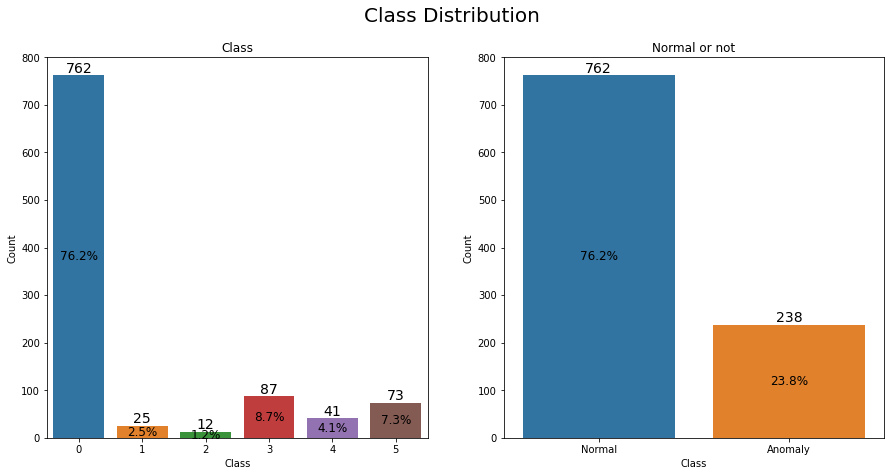

In [192]:
# 'Normal-Anomaly' 비율 그래프
sum_ = klarf_info.Class.count()
anomaly_cnt = klarf_info[~(klarf_info.Class == 0)].Class.value_counts().sum()
normal_cnt = klarf_info[(klarf_info.Class == 0)].Class.count()

cnt = pd.DataFrame([["Normal", normal_cnt],["Anomaly", anomaly_cnt]], columns=["Class", "Counts"])

fig, axes = plt.subplots(ncols=2, figsize=(15,7))

ax1 = sns.countplot(data=klarf_info, x='Class', ax=axes[0])
ax2 = sns.barplot(data=cnt, x='Class', y='Counts', ax=axes[1])

for ax in [ax1, ax2]:
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.bar_label(ax.containers[0], fontsize=14)
    for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_y() + p.get_height()/2
        percentage = '{:.1f}%'.format(p.get_height()/(sum_)*100)
        ax.text(
            x, y, percentage, ha='center', va='center', fontsize=12
        )
    
ax1.set_title("Class")
ax2.set_title("Normal or not")

fig.suptitle("Class Distribution", fontsize=20)
plt.show()

In [182]:
klarf_info["Step-ID"].value_counts()

Metrology-Type-01    676
Metrology-type-01    168
Metrology-Type-02    106
Metrology-type-02     50
Name: Step-ID, dtype: int64

In [187]:
klarf_info["Step-ID"] = klarf_info["Step-ID"].apply(lambda x: x.split('-')[0]+
                                                    '-'+'T'+x.split('-')[1][1:]+
                                                    '-'+x.split('-')[2])

Metrology-Type-01    844
Metrology-Type-02    156
Name: Step-ID, dtype: int64

In [190]:
klarf_info["Wafer-ID"].value_counts()

AS10050-23    3
AS10050-25    3
AS10016-11    3
AS10016-09    3
AS10016-08    3
             ..
AS10033-12    1
AC10021-05    1
AS10033-13    1
AS10033-14    1
AC10358-25    1
Name: Wafer-ID, Length: 825, dtype: int64

In [265]:
klarf_info[klarf_info["Wafer-ID"] == 'AS10033-13'] # TSV 공정

,Lot-ID,Wafer-ID,ResultTimestamp,Machine-ID,Step-ID,Device-ID,Class
374,AS10033SS,AS10033-13,01-04-23 10:21:17,A3D02,Metrology-Type-01,AS1,0


In [197]:
klarf_info[klarf_info["Lot-ID"] == 'AS10050TT']["Wafer-ID"].value_counts()

AS10050-01    3
AS10050-15    3
AS10050-03    3
AS10050-23    3
AS10050-21    3
AS10050-19    3
AS10050-17    3
AS10050-25    3
AS10050-13    3
AS10050-09    3
AS10050-07    3
AS10050-05    3
AS10050-11    3
AS10050-14    2
AS10050-22    2
AS10050-20    2
AS10050-18    2
AS10050-16    2
AS10050-08    2
AS10050-12    2
AS10050-10    2
AS10050-06    2
AS10050-04    2
AS10050-02    2
AS10050-24    2
Name: Wafer-ID, dtype: int64

---
## 질문사항 및 답변
1. 모든 컬럼에 대한 details
2. Step-ID 컬럼의 Type, type 부분이 같은 의미인지?
3. Lot-ID, Device-ID가 같은 의미인지? 한 라인에서 쓰는 장비가 1개인지?
4. 한 lot에서 동일 Wafer-ID가 최대 3개 나오는데, 현업에서도 실제로 이런지? 
5. klarf 파일에서 defect list 의미 - defect die 좌표 / defect array in die, 
6. Machine - Device 차이
    - Machine-ID : 가명처리 한 반도체 검사 장비 ID
7. wafer-id가 같다는 의미? 동일한 제품이라는 의미?
8. 한 Lot에서 wafer 종류가 25개인데, 한 공정에서 25종의 wafer가 나오는건지?
9. 이상 데이터의 비율이 너무 큰데, 해도 문제 없는지?

A3D1 : bump 검사장비
이물질로 인한 높이 차이를 defect로 결정.

위 공정을 step으로 표현
A   B   C   D 공정
C Step에서 defect 발견 시, die 제거.

수율 스펙에 미달하면 알람하는 시스템이 이미 구현되어있지만,
시간흐름을 고려하지 않아서, 수율 스펙을 만족하더라도 결점이 지속적으로 발생한다.
이를 해결하고자 함.

시나리오
1. 2개
2. 
3. 
4. 
5. 